# cnn-deblur

This project aims at developing a Deep Neural Network able to deblur images, as part of the **Deep Learning** course of the **Master in Artificial Intelligence** (*Alma Mater Studiorum*).  
This DNN should be able to correct both gaussian and motion blur, by training on Cifar10 and REDS datasets.

Authors:
 - Mattia Orlandi
 - Giacomo Pinardi

## Premises
Import necessary libraries.

In [ ]:
import tensorflow as tf
import numpy as np
import os

tf.get_logger().setLevel("ERROR")
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.3.0


Mount Google Drive to save checkpoints.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Access to GCP to retrieve the dataset.

In [ ]:
from google.colab import auth

auth.authenticate_user()

project_id = "cnn-deblur"
bucket_name = "cnn-d3blur-buck3t"
!gcloud config set project {project_id}

!gsutil -m acl -r ch -u service-495559152420@cloud-tpu.iam.gserviceaccount.com:READER gs://{bucket_name}

Updated property [core/project].
No changes to gs://cnn-d3blur-buck3t/REDS/
No changes to gs://cnn-d3blur-buck3t/REDS/test/
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS002.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS008.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS005.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS001.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS009.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS010.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS000.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS004.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS003.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS006.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS007.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS011.tfrecords
No changes to gs://cnn-d3blur-buck3t/REDS/test/REDS012.tfrecords
No changes to gs://cnn-d3blur-b

Connect to TPU to speed-up training time.

In [ ]:
print('Trying to connect to TPU runtime...')
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.TPUStrategy(tpu)

print("REPLICAS: ", strategy.num_replicas_in_sync)

Trying to connect to TPU runtime...
Running on TPU  ['10.33.160.210:8470']
REPLICAS:  8


Connect to GitHub, download the required Python modules from the repository.

In [ ]:
from getpass import getpass
import urllib

# Change working directory
os.chdir('/content')

# Remove all from directory
! rm -r 'cnn-deblur'

# Read credentials to GitHub
user = input('User name: ')
password = getpass('Password: ')
password = urllib.parse.quote(password)

cmd_string = 'git clone https://{0:s}:{1:s}@github.com/nihil21/cnn-deblur.git'.format(user, password)

os.system(cmd_string)
cmd_string, password = "", ""

rm: cannot remove 'cnn-deblur': No such file or directory
User name: nihil21
Password: ··········


Change working directory.

In [ ]:
# Move inside cloned repository
os.chdir(os.path.join('cnn-deblur', 'cnn-deblur'))
print(os.getcwd())

/content/cnn-deblur/cnn-deblur


Import the Python modules and other relevant libraries.

In [ ]:
from models.conv_net import ConvNet
from models.resnet import ResNet16
from models.unet import UNet16
from models.rednet import REDNet30, REDNet30WGAN
from models.ms_deblur_wgan import MSDeblurWGAN
from datasets import cifar_dataset, reds_dataset
from datasets.dataset_utils import extract_patches_from_dataset, extract_patches, reconstruct_image

from keras.utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## 1. Cifar10

### Approach 1: ConvNet
This approach consists in using a standard CNN (wrapped in a specific object, subtype of the abstract ConvNet class); as loss function, LogCosh is chosen.

#### ResNet16
The first architecture experimented was a ResNet with 16 layers.

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_0 (Conv2D)                (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn1_0 (BatchNormalization)      (None, 32, 32, 64)   256         conv1_0[0][0]                    
__________________________________________________________________________________________________
relu1_0 (Activation)            (None, 32, 32, 64)   0           bn1_0[0][0]                      
_______________________________________________________________________________________

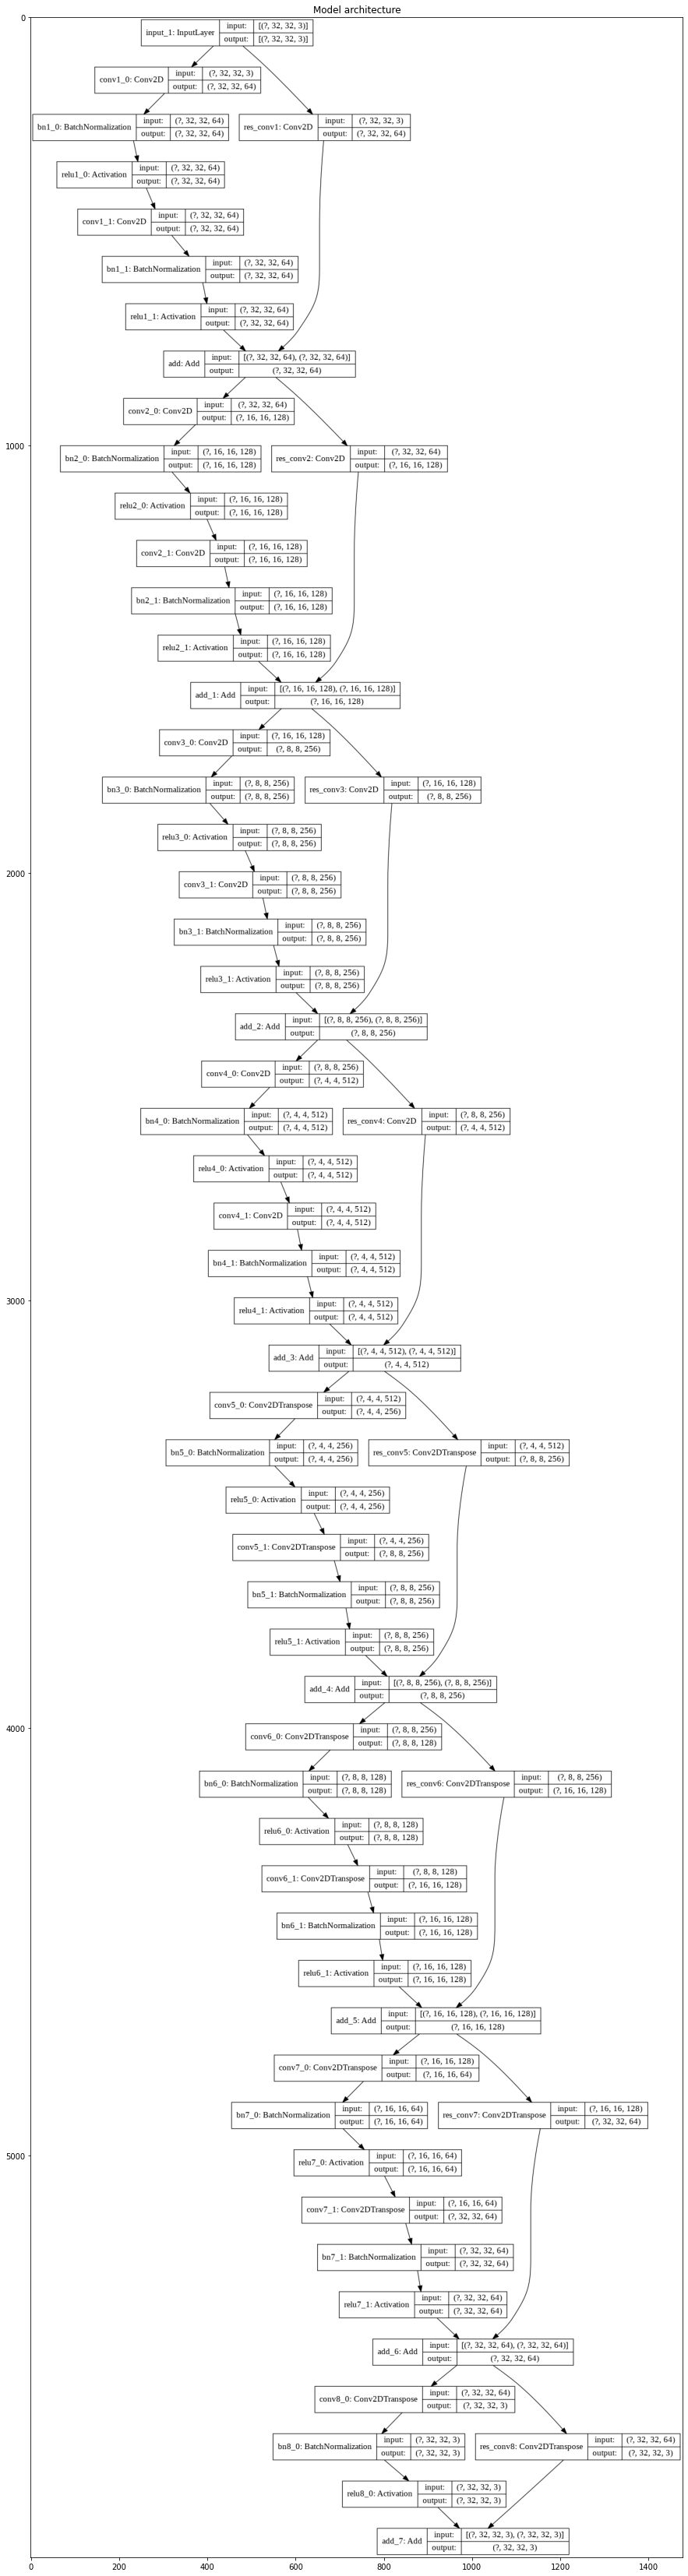

In [ ]:
# Create ResNet16 and plot model
with strategy.scope():
  resnet16: ConvNet = ResNet16(input_shape=(32, 32, 3))
  LEARNING_RATE = 0.001
  resnet16.compile(loss='logcosh', lr=LEARNING_RATE)

resnet16.summary()
path_to_model = os.path.join('..', 'res', 'model.png')
resnet16.plot_model(path_to_model)
fig, ax = plt.subplots(figsize=(15, 60))
ax.set_title('Model architecture')
plt.imshow(mpimg.imread(path_to_model), aspect='auto');
init_ep = 0

Load Cifar10 dataset from GCS.

In [ ]:
EP = 120
BS = 32 * strategy.num_replicas_in_sync

TRAINVAL_SIZE = 50000
VAL_SPLIT = 0.125
VAL_SIZE = int(VAL_SPLIT * TRAINVAL_SIZE)
TRAIN_SIZE = TRAINVAL_SIZE - VAL_SIZE
TEST_SIZE = 10000

# Load cifar10 dataset from GCS
train_data, test_data, val_data = cifar_dataset.load_data(BS, EP, VAL_SIZE)

steps_train = TRAIN_SIZE // BS + 1
steps_val = VAL_SIZE // BS + 1

print(f'Training set size: {TRAIN_SIZE}')
print(f'Validation set size: {VAL_SIZE}')
print(f'Test set size: {TEST_SIZE}')
print(f'Training step: {steps_train}')
print(f'Validation step: {steps_val}')

Training set size: 43750
Validation set size: 6250
Test set size: 10000
Training step: 171
Validation step: 25


Prepare callback function to save weights to Drive.

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

filepath = '/content/drive/My Drive/cnn-deblur/weights/cifar10/resnet16/ep:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto', save_freq='epoch', period=15)
callbacks_list = [checkpoint]

Optionally load weights from previous run.

In [ ]:
import glob

init_ep = int(input('Initial epoch: '))

weights = glob.glob('/content/drive/My Drive/cnn-deblur/weights/cifar10/resnet16/ep:{0:03d}-val_loss:*.hdf5'.format(init_ep))
resnet16.model.load_weights(weights[0])

Train model following *train-validation-test* paradigm.

In [ ]:
print('Initial epoch: {0:d}'.format(init_ep))

hist = resnet16.fit(train_data,
                    epochs=EP,
                    steps_per_epoch=steps_train,
                    validation_data=val_data,
                    validation_steps=steps_val,
                    initial_epoch=init_ep,
                    callbacks=callbacks_list);

Initial epoch: 0
Epoch 1/120
171/171 [==============================] - 125s 729ms/step - loss: 0.0247 - ssim: 0.3143 - psnr: 15.7665 - mse: 0.0855 - mae: 0.1435 - accuracy: 0.4530 - val_loss: 0.0257 - val_ssim: 0.2338 - val_psnr: 13.5211 - val_mse: 0.0524 - val_mae: 0.1856 - val_accuracy: 0.4717
Epoch 2/120
171/171 [==============================] - 10s 60ms/step - loss: 0.0062 - ssim: 0.5653 - psnr: 19.6216 - mse: 0.0128 - mae: 0.0814 - accuracy: 0.5903 - val_loss: 0.0127 - val_ssim: 0.4723 - val_psnr: 16.4364 - val_mse: 0.0256 - val_mae: 0.1321 - val_accuracy: 0.4973
Epoch 3/120
171/171 [==============================] - 10s 61ms/step - loss: 0.0044 - ssim: 0.6539 - psnr: 21.0154 - mse: 0.0090 - mae: 0.0700 - accuracy: 0.6531 - val_loss: 0.0048 - val_ssim: 0.6613 - val_psnr: 20.7144 - val_mse: 0.0096 - val_mae: 0.0761 - val_accuracy: 0.6428
Epoch 4/120
171/171 [==============================] - 10s 61ms/step - loss: 0.0037 - ssim: 0.6994 - psnr: 21.8324 - mse: 0.0074 - mae: 0.0634 -

Plot graphs representing the loss and metrics trends over epochs.

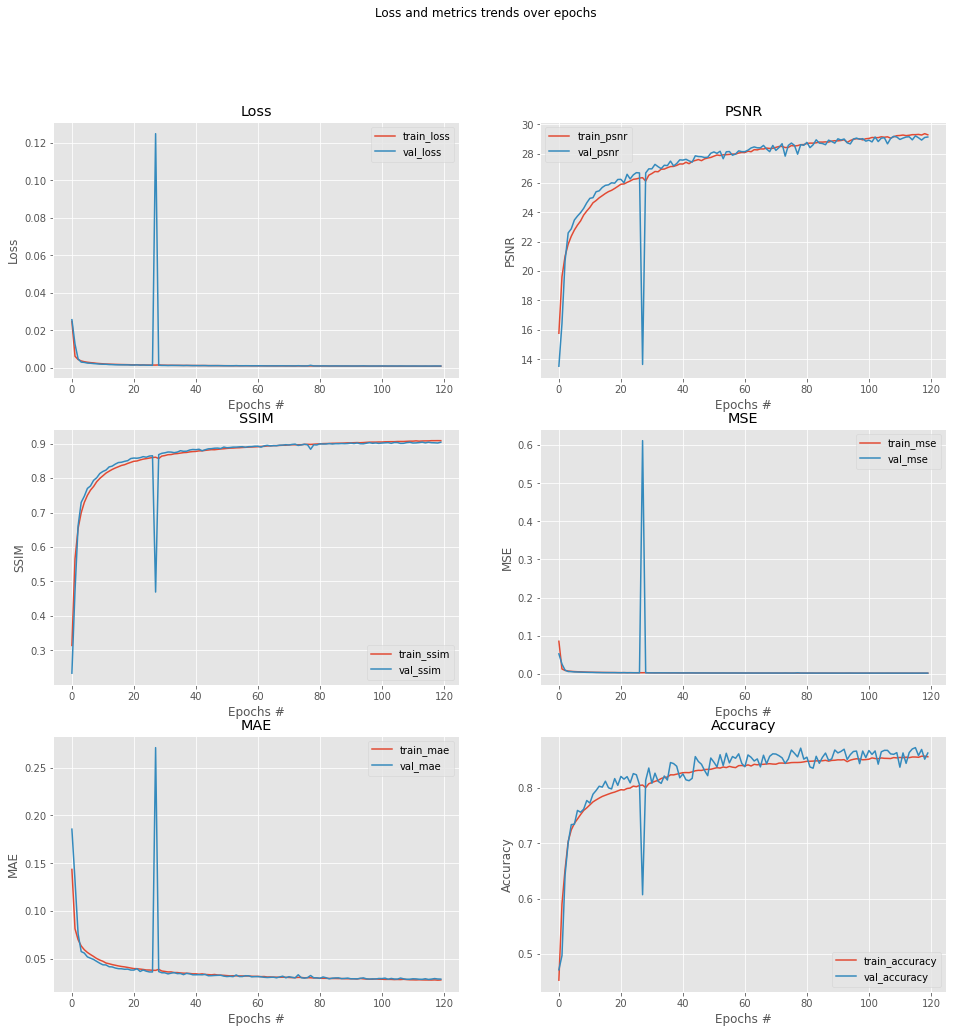

In [ ]:
n = np.arange(0, EP - init_ep)
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
fig.suptitle('Loss and metrics trends over epochs')
# Loss
axes[0, 0].plot(n, hist.history['loss'], label='train_loss')
axes[0, 0].plot(n, hist.history['val_loss'], label='val_loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set(xlabel='Epochs #', ylabel='Loss')
axes[0, 0].legend();
# PSNR
axes[0, 1].plot(n, hist.history['psnr'], label='train_psnr')
axes[0, 1].plot(n, hist.history['val_psnr'], label='val_psnr')
axes[0, 1].set_title('PSNR')
axes[0, 1].set(xlabel='Epochs #', ylabel='PSNR')
axes[0, 1].legend();
# SSIM
axes[1, 0].plot(n, hist.history['ssim'], label='train_ssim')
axes[1, 0].plot(n, hist.history['val_ssim'], label='val_ssim')
axes[1, 0].set_title('SSIM')
axes[1, 0].set(xlabel='Epochs #', ylabel='SSIM')
axes[1, 0].legend();
# MSE
axes[1, 1].plot(n, hist.history['mse'], label='train_mse')
axes[1, 1].plot(n, hist.history['val_mse'], label='val_mse')
axes[1, 1].set_title('MSE')
axes[1, 1].set(xlabel='Epochs #', ylabel='MSE')
axes[1, 1].legend();
# MAE
axes[2, 0].plot(n, hist.history['mae'], label='train_mae')
axes[2, 0].plot(n, hist.history['val_mae'], label='val_mae')
axes[2, 0].set_title('MAE')
axes[2, 0].set(xlabel='Epochs #', ylabel='MAE')
axes[2, 0].legend();
# Accuracy
axes[2, 1].plot(n, hist.history['accuracy'], label='train_accuracy')
axes[2, 1].plot(n, hist.history['val_accuracy'], label='val_accuracy')
axes[2, 1].set_title('Accuracy')
axes[2, 1].set(xlabel='Epochs #', ylabel='Accuracy')
axes[2, 1].legend();

Evaluate the model on the test set.

In [ ]:
steps_test = TEST_SIZE // BS
results = resnet16.evaluate(test_data, steps=steps_test)

print('Test loss:', results[0])
print('Test ssim:', results[1])
print('Test psnr:', results[2])
print('Test mse:', results[3])
print('Test mae:', results[4])
print('Test accuracy:', results[5])

39/39 [==============================] - 21s 549ms/step - loss: 9.7942e-04 - ssim: 0.9034 - psnr: 29.0887 - mse: 0.0020 - mae: 0.0289 - accuracy: 0.8651
Test loss: 0.0009794243378564715
Test ssim: 0.9033806920051575
Test psnr: 29.08865737915039
Test mse: 0.001965452916920185
Test mae: 0.028883814811706543
Test accuracy: 0.865115761756897


Generate predictions on new data.

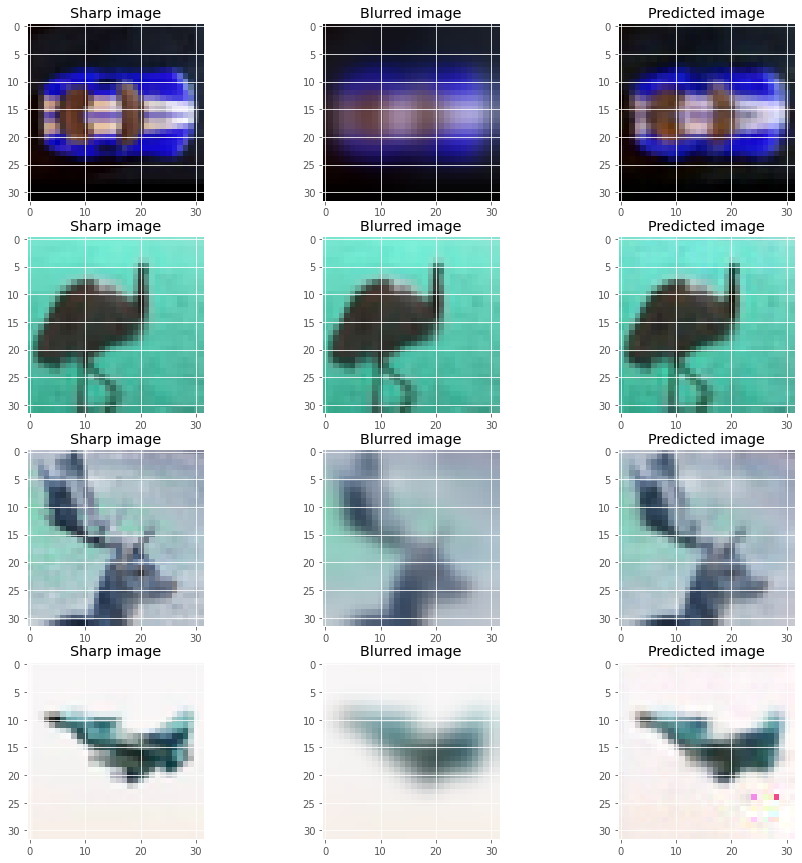

In [ ]:
for batch in test_data.take(1):
  blurred = tf.cast(batch[0], tf.float32)
  sharp = tf.cast(batch[1], tf.float32)
  predicted = tf.cast(resnet16.predict(blurred), tf.float32)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for i in range(4):
  axes[i, 0].set_title('Sharp image')
  axes[i, 0].imshow(sharp[i]);
  axes[i, 1].set_title('Blurred image')
  axes[i, 1].imshow(blurred[i]);
  axes[i, 2].set_title('Predicted image')
  axes[i, 2].imshow(predicted[i]);

#### UNet16
The second architecture experimented was a UNet with 16 layers.

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_0 (Conv2D)                (None, 32, 32, 16)   448         input_3[0][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 32, 16)   2320        conv1_0[0][0]                    
__________________________________________________________________________________________________
pool2 (MaxPooling2D)            (None, 16, 16, 16)   0           conv1_1[0][0]                    
_______________________________________________________________________________________

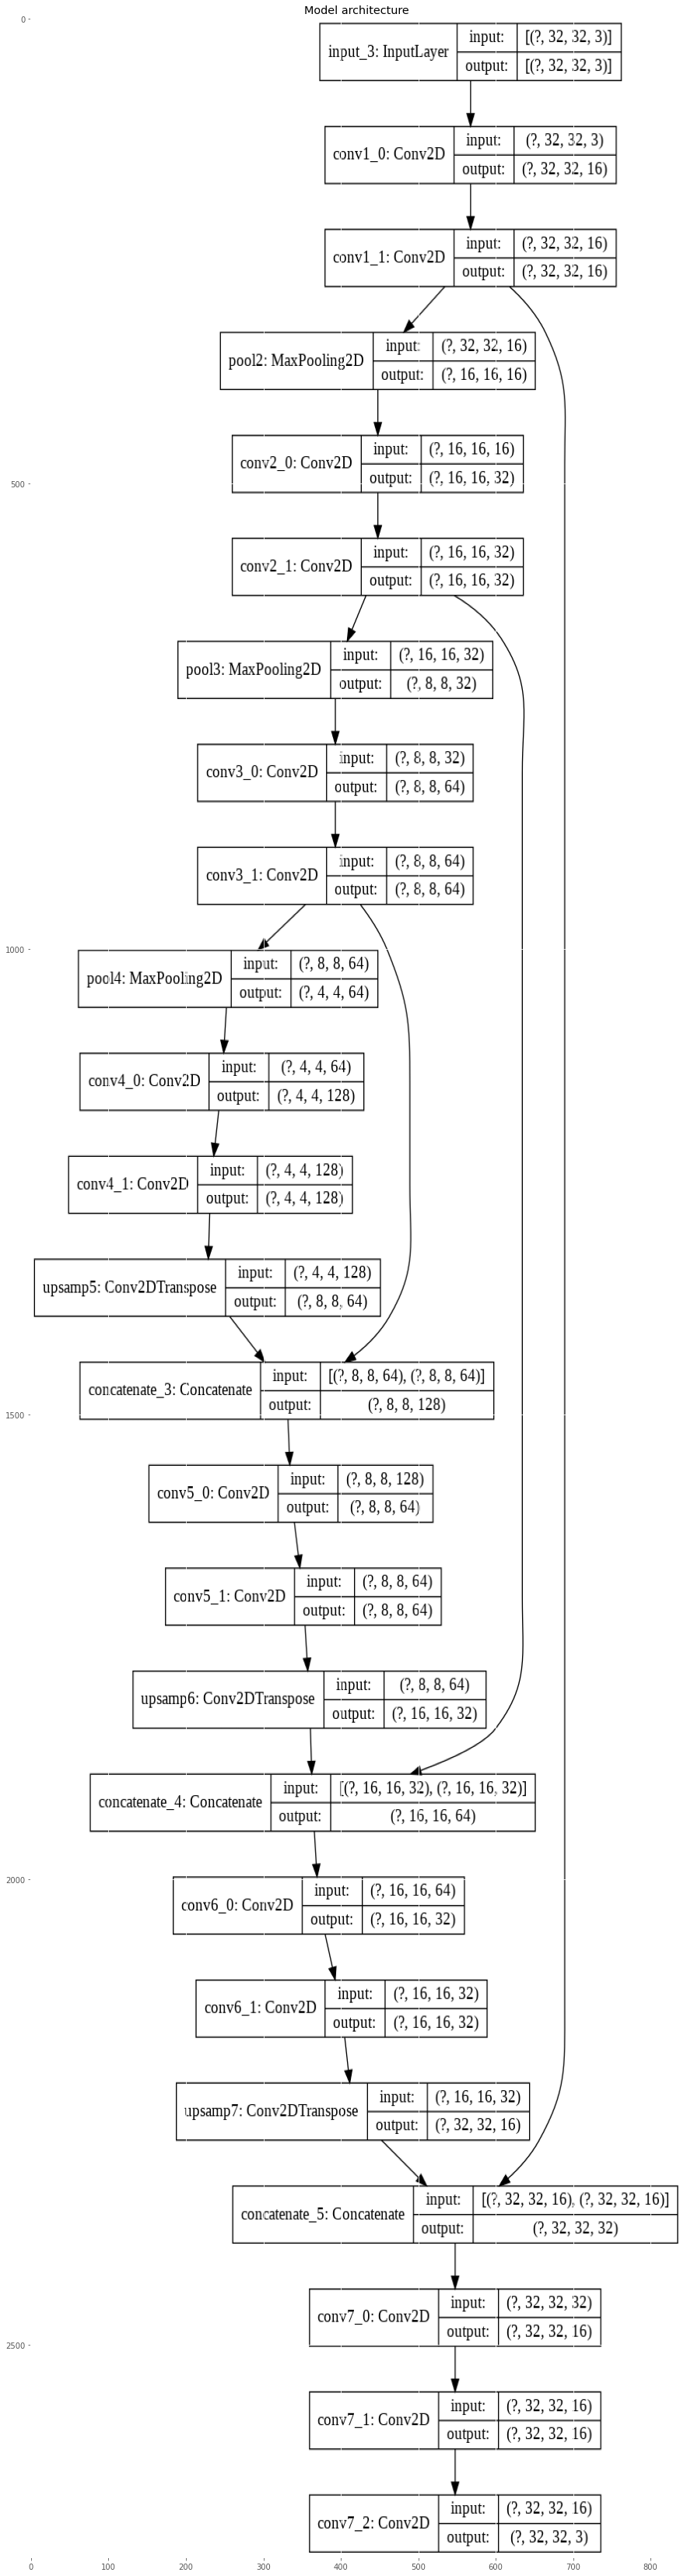

In [ ]:
# Create UNet16 and plot model
with strategy.scope():
  unet16: ConvNet = UNet16(input_shape=(32, 32, 3))
  LEARNING_RATE = 0.001
  unet16.compile(loss='logcosh', lr=LEARNING_RATE)

unet16.summary()
path_to_model = os.path.join('..', 'res', 'model.png')
unet16.plot_model(path_to_model)
fig, ax = plt.subplots(figsize=(15, 60))
ax.set_title('Model architecture')
plt.imshow(mpimg.imread(path_to_model), aspect='auto');
init_ep = 0

Load Cifar10 dataset from GCS.

In [ ]:
EP = 120
BS = 32 * strategy.num_replicas_in_sync

TRAINVAL_SIZE = 50000
VAL_SPLIT = 0.125
VAL_SIZE = int(VAL_SPLIT * TRAINVAL_SIZE)
TRAIN_SIZE = TRAINVAL_SIZE - VAL_SIZE
TEST_SIZE = 10000

# Load cifar10 dataset from GCS
train_data, test_data, val_data = cifar_dataset.load_data(BS, EP, VAL_SIZE)

steps_train = TRAIN_SIZE // BS + 1
steps_val = VAL_SIZE // BS + 1

print(f'Training set size: {TRAIN_SIZE}')
print(f'Validation set size: {VAL_SIZE}')
print(f'Test set size: {TEST_SIZE}')
print(f'Training step: {steps_train}')
print(f'Validation step: {steps_val}')

Training set size: 43750
Validation set size: 6250
Test set size: 10000
Training step: 171
Validation step: 25


Prepare callback function to save weights to Drive.

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

filepath = '/content/drive/My Drive/cnn-deblur/weights/cifar10/unet16/ep:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto', save_freq='epoch', period=15)
callbacks_list = [checkpoint]

Optionally load weights from previous run.

In [ ]:
import glob

init_ep = int(input('Initial epoch: '))

weights = glob.glob('/content/drive/My Drive/cnn-deblur/weights/cifar10/unet16/ep:{0:03d}-val_loss:*.hdf5'.format(init_ep))
unet16.model.load_weights(weights[0])

Train model following *train-validation-test* paradigm.

In [ ]:
print('Initial epoch: {0:d}'.format(init_ep))

hist = unet16.fit(train_data,
                  epochs=EP,
                  steps_per_epoch=steps_train,
                  validation_data=val_data,
                  validation_steps=steps_val,
                  initial_epoch=init_ep,
                  callbacks=callbacks_list);

Initial epoch: 0
Epoch 1/120
171/171 [==============================] - 112s 656ms/step - loss: 0.0132 - ssim: 0.5962 - psnr: 19.4997 - mse: 0.0275 - mae: 0.1017 - accuracy: 0.6036 - val_loss: 0.0031 - val_ssim: 0.7325 - val_psnr: 23.0980 - val_mse: 0.0063 - val_mae: 0.0549 - val_accuracy: 0.7863
Epoch 2/120
171/171 [==============================] - 8s 47ms/step - loss: 0.0029 - ssim: 0.7455 - psnr: 23.4703 - mse: 0.0059 - mae: 0.0529 - accuracy: 0.8053 - val_loss: 0.0029 - val_ssim: 0.7576 - val_psnr: 23.5894 - val_mse: 0.0058 - val_mae: 0.0527 - val_accuracy: 0.8163
Epoch 3/120
171/171 [==============================] - 8s 45ms/step - loss: 0.0026 - ssim: 0.7732 - psnr: 24.1646 - mse: 0.0051 - mae: 0.0491 - accuracy: 0.8131 - val_loss: 0.0024 - val_ssim: 0.7875 - val_psnr: 24.3304 - val_mse: 0.0048 - val_mae: 0.0481 - val_accuracy: 0.7785
Epoch 4/120
171/171 [==============================] - 8s 46ms/step - loss: 0.0022 - ssim: 0.7977 - psnr: 24.7614 - mse: 0.0045 - mae: 0.0458 - ac

Plot graphs representing the loss and metrics trends over epochs.

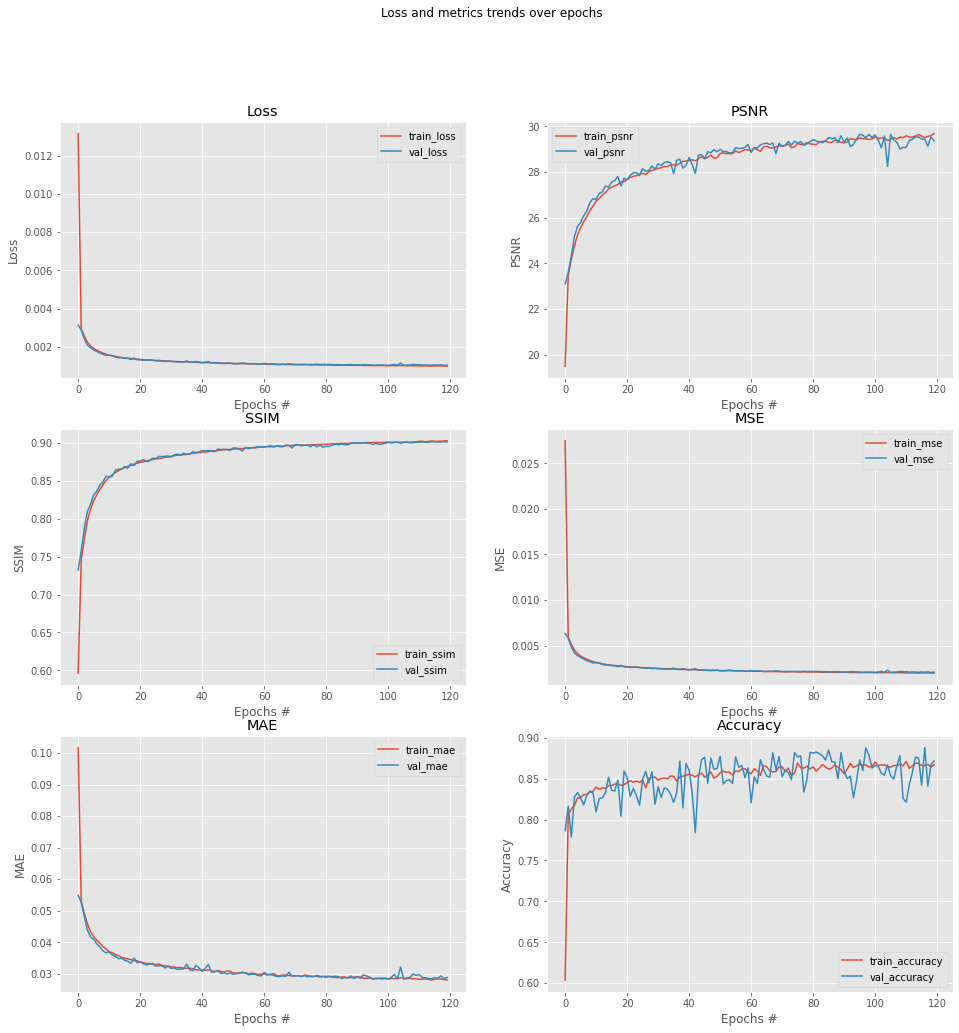

In [ ]:
n = np.arange(0, EP - init_ep)
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
fig.suptitle('Loss and metrics trends over epochs')
# Loss
axes[0, 0].plot(n, hist.history['loss'], label='train_loss')
axes[0, 0].plot(n, hist.history['val_loss'], label='val_loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set(xlabel='Epochs #', ylabel='Loss')
axes[0, 0].legend();
# PSNR
axes[0, 1].plot(n, hist.history['psnr'], label='train_psnr')
axes[0, 1].plot(n, hist.history['val_psnr'], label='val_psnr')
axes[0, 1].set_title('PSNR')
axes[0, 1].set(xlabel='Epochs #', ylabel='PSNR')
axes[0, 1].legend();
# SSIM
axes[1, 0].plot(n, hist.history['ssim'], label='train_ssim')
axes[1, 0].plot(n, hist.history['val_ssim'], label='val_ssim')
axes[1, 0].set_title('SSIM')
axes[1, 0].set(xlabel='Epochs #', ylabel='SSIM')
axes[1, 0].legend();
# MSE
axes[1, 1].plot(n, hist.history['mse'], label='train_mse')
axes[1, 1].plot(n, hist.history['val_mse'], label='val_mse')
axes[1, 1].set_title('MSE')
axes[1, 1].set(xlabel='Epochs #', ylabel='MSE')
axes[1, 1].legend();
# MAE
axes[2, 0].plot(n, hist.history['mae'], label='train_mae')
axes[2, 0].plot(n, hist.history['val_mae'], label='val_mae')
axes[2, 0].set_title('MAE')
axes[2, 0].set(xlabel='Epochs #', ylabel='MAE')
axes[2, 0].legend();
# Accuracy
axes[2, 1].plot(n, hist.history['accuracy'], label='train_accuracy')
axes[2, 1].plot(n, hist.history['val_accuracy'], label='val_accuracy')
axes[2, 1].set_title('Accuracy')
axes[2, 1].set(xlabel='Epochs #', ylabel='Accuracy')
axes[2, 1].legend();

Evaluate the model on the test set.

In [ ]:
steps_test = TEST_SIZE // BS
results = unet16.evaluate(test_data, steps=steps_test)

print('Test loss:', results[0])
print('Test ssim:', results[1])
print('Test psnr:', results[2])
print('Test mse:', results[3])
print('Test mae:', results[4])
print('Test accuracy:', results[5])

39/39 [==============================] - 14s 366ms/step - loss: 0.0010 - ssim: 0.9001 - psnr: 29.3175 - mse: 0.0021 - mae: 0.0290 - accuracy: 0.8728
Test loss: 0.0010436889715492725
Test ssim: 0.9001203775405884
Test psnr: 29.317527770996094
Test mse: 0.002095316769555211
Test mae: 0.028981227427721024
Test accuracy: 0.8728370070457458


Generate predictions on new data.

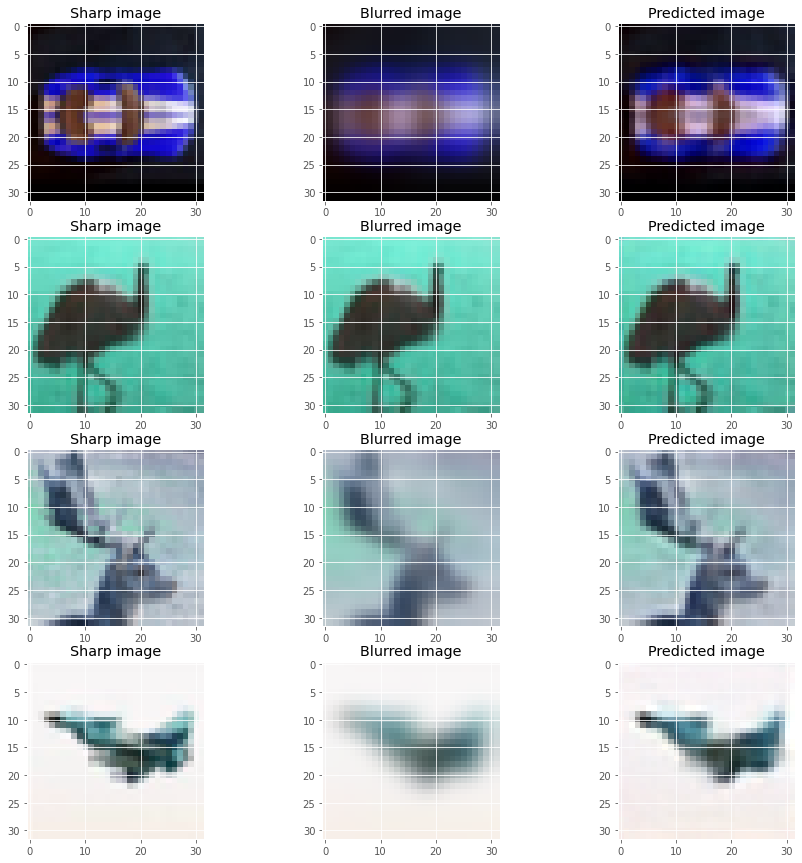

In [ ]:
for batch in test_data.take(1):
  blurred = tf.cast(batch[0], tf.float32)
  sharp = tf.cast(batch[1], tf.float32)
  predicted = tf.cast(unet16.predict(blurred), tf.float32)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for i in range(4):
  axes[i, 0].set_title('Sharp image')
  axes[i, 0].imshow(sharp[i]);
  axes[i, 1].set_title('Blurred image')
  axes[i, 1].imshow(blurred[i]);
  axes[i, 2].set_title('Predicted image')
  axes[i, 2].imshow(predicted[i]);

#### REDNet30
The final architecture experimented was a REDNet with 30 layers.

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
encode_conv0 (Conv2D)           (None, None, None, 6 1792        input_4[0][0]                    
__________________________________________________________________________________________________
encode_act0 (ELU)               (None, None, None, 6 0           encode_conv0[0][0]               
__________________________________________________________________________________________________
encode_bn0 (BatchNormalization) (None, None, None, 6 256         encode_act0[0][0]                
_______________________________________________________________________________________

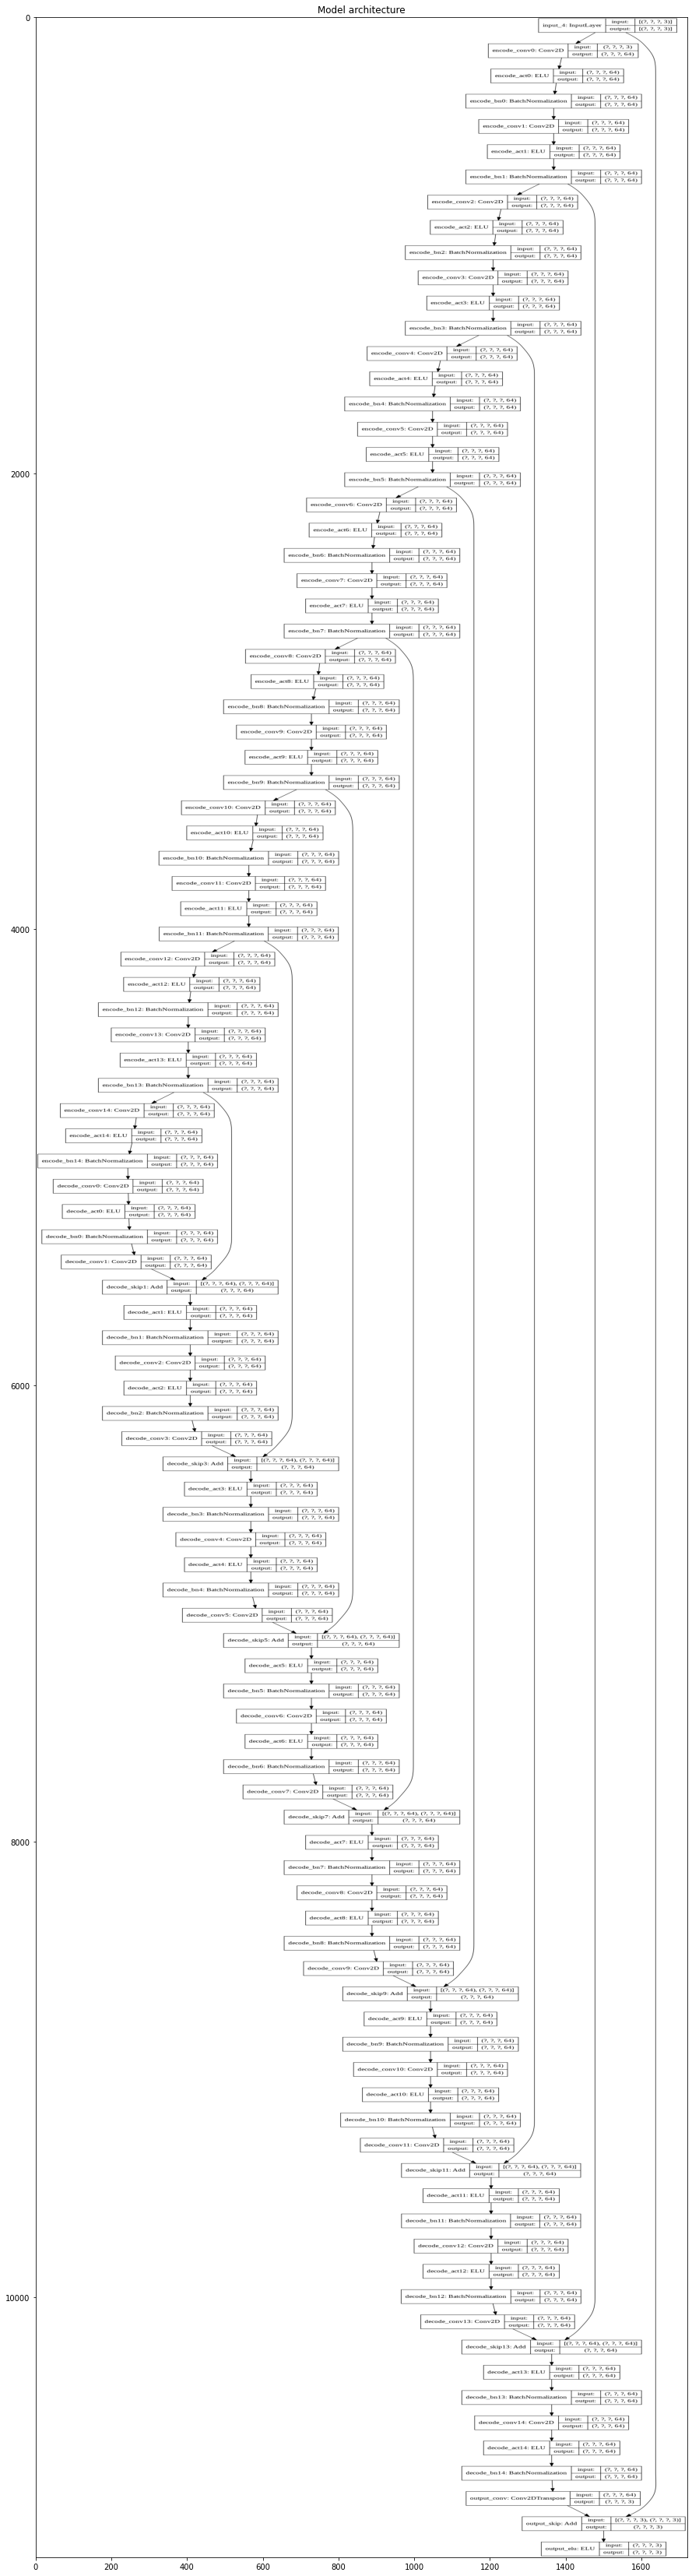

In [ ]:
# Create REDNet30 and plot model
with strategy.scope():
  rednet30: ConvNet = REDNet30(input_shape=(None, None, 3))
  LEARNING_RATE = 0.001
  rednet30.compile(loss='logcosh', lr=LEARNING_RATE, use_nesterov=False)

rednet30.summary()
path_to_model = os.path.join('..', 'res', 'model.png')
rednet30.plot_model(path_to_model)
fig, ax = plt.subplots(figsize=(15, 60))
ax.set_title('Model architecture')
plt.imshow(mpimg.imread(path_to_model), aspect='auto');
init_ep = 0

Load Cifar10 dataset from GCS.

In [ ]:
EP = 50
BS = 32 * strategy.num_replicas_in_sync

TRAINVAL_SIZE = 50000
VAL_SPLIT = 0.125
VAL_SIZE = int(VAL_SPLIT * TRAINVAL_SIZE)
TRAIN_SIZE = TRAINVAL_SIZE - VAL_SIZE
TEST_SIZE = 10000

# Load cifar10 dataset from GCS
train_data, test_data, val_data = cifar_dataset.load_data(BS, EP, VAL_SIZE)

steps_train = TRAIN_SIZE // BS + 1
steps_val = VAL_SIZE // BS + 1

print(f'Training set size: {TRAIN_SIZE}')
print(f'Validation set size: {VAL_SIZE}')
print(f'Test set size: {TEST_SIZE}')
print(f'Training step: {steps_train}')
print(f'Validation step: {steps_val}')

Training set size: 43750
Validation set size: 6250
Test set size: 10000
Training step: 171
Validation step: 25


Prepare callback function to save weights to Drive.

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

filepath = '/content/drive/My Drive/cnn-deblur/weights/cifar10/rednet30n/ep:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto', save_freq='epoch', period=15)
callbacks_list = [checkpoint]

Optionally prepare callback function to decrease the learning rate.

In [ ]:
from math import floor

# Learning rate decay
DROP_RATE = 0.7
EPOCH_DROP = 5
lr_decay = tf.keras.callbacks.LearningRateScheduler(
  lambda epoch: LEARNING_RATE * DROP_RATE ** floor((epoch - init_ep)/EPOCH_DROP),
  verbose=True)

callbacks_list.append(lr_decay)

Optionally load weights from previous run.

In [ ]:
import glob

init_ep = int(input('Initial epoch: '))

weights = glob.glob('/content/drive/My Drive/cnn-deblur/weights/cifar10/rednet30/ep:{0:03d}-val_loss:*.hdf5'.format(init_ep))
rednet30.model.load_weights(weights[0])

Initial epoch: 120


Train model following *train-validation-test* paradigm.

In [ ]:
print('Initial epoch: {0:d}'.format(init_ep))

hist = rednet30.fit(train_data,
                    epochs=EP,
                    steps_per_epoch=steps_train,
                    validation_data=val_data,
                    validation_steps=steps_val,
                    initial_epoch=init_ep,
                    callbacks=callbacks_list);

Initial epoch: 0
Epoch 1/50
171/171 [==============================] - 177s 1s/step - loss: 0.0195 - ssim: 0.5922 - psnr: 18.6929 - mse: 0.0464 - mae: 0.1146 - accuracy: 0.5929 - val_loss: 0.0140 - val_ssim: 0.6685 - val_psnr: 15.7746 - val_mse: 0.0286 - val_mae: 0.1256 - val_accuracy: 0.5389
Epoch 2/50
171/171 [==============================] - 19s 113ms/step - loss: 0.0036 - ssim: 0.7203 - psnr: 22.3856 - mse: 0.0072 - mae: 0.0608 - accuracy: 0.7020 - val_loss: 0.0039 - val_ssim: 0.7322 - val_psnr: 21.7470 - val_mse: 0.0079 - val_mae: 0.0649 - val_accuracy: 0.6394
Epoch 3/50
171/171 [==============================] - 19s 113ms/step - loss: 0.0028 - ssim: 0.7685 - psnr: 23.4853 - mse: 0.0057 - mae: 0.0534 - accuracy: 0.7330 - val_loss: 0.0029 - val_ssim: 0.7825 - val_psnr: 23.4415 - val_mse: 0.0057 - val_mae: 0.0547 - val_accuracy: 0.6759
Epoch 4/50
171/171 [==============================] - 19s 114ms/step - loss: 0.0022 - ssim: 0.8157 - psnr: 24.6138 - mse: 0.0045 - mae: 0.0470 - acc

Plot graphs representing the loss and metrics trends over epochs.

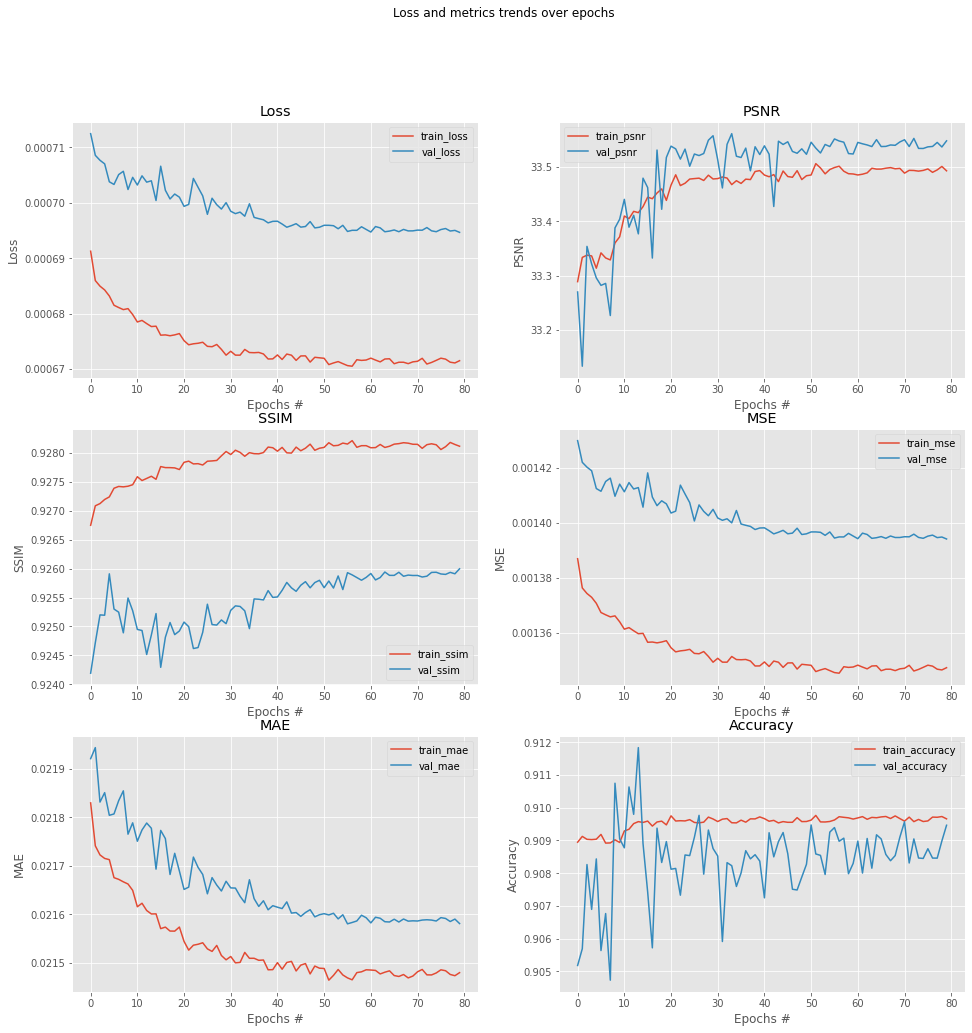

In [ ]:
n = np.arange(0, EP - init_ep)
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
fig.suptitle('Loss and metrics trends over epochs')
# Loss
axes[0, 0].plot(n, hist.history['loss'], label='train_loss')
axes[0, 0].plot(n, hist.history['val_loss'], label='val_loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set(xlabel='Epochs #', ylabel='Loss')
axes[0, 0].legend();
# PSNR
axes[0, 1].plot(n, hist.history['psnr'], label='train_psnr')
axes[0, 1].plot(n, hist.history['val_psnr'], label='val_psnr')
axes[0, 1].set_title('PSNR')
axes[0, 1].set(xlabel='Epochs #', ylabel='PSNR')
axes[0, 1].legend();
# SSIM
axes[1, 0].plot(n, hist.history['ssim'], label='train_ssim')
axes[1, 0].plot(n, hist.history['val_ssim'], label='val_ssim')
axes[1, 0].set_title('SSIM')
axes[1, 0].set(xlabel='Epochs #', ylabel='SSIM')
axes[1, 0].legend();
# MSE
axes[1, 1].plot(n, hist.history['mse'], label='train_mse')
axes[1, 1].plot(n, hist.history['val_mse'], label='val_mse')
axes[1, 1].set_title('MSE')
axes[1, 1].set(xlabel='Epochs #', ylabel='MSE')
axes[1, 1].legend();
# MAE
axes[2, 0].plot(n, hist.history['mae'], label='train_mae')
axes[2, 0].plot(n, hist.history['val_mae'], label='val_mae')
axes[2, 0].set_title('MAE')
axes[2, 0].set(xlabel='Epochs #', ylabel='MAE')
axes[2, 0].legend();
# Accuracy
axes[2, 1].plot(n, hist.history['accuracy'], label='train_accuracy')
axes[2, 1].plot(n, hist.history['val_accuracy'], label='val_accuracy')
axes[2, 1].set_title('Accuracy')
axes[2, 1].set(xlabel='Epochs #', ylabel='Accuracy')
axes[2, 1].legend();

Evaluate the model on the test set.

In [ ]:
steps_test = TEST_SIZE // BS
results = rednet30.evaluate(test_data, steps=steps_test)

print('Test loss:', results[0])
print('Test ssim:', results[1])
print('Test psnr:', results[2])
print('Test mse:', results[3])
print('Test mae:', results[4])
print('Test accuracy:', results[5])

39/39 [==============================] - 18s 470ms/step - loss: 6.9663e-04 - ssim: 0.9258 - psnr: 33.5159 - mse: 0.0014 - mae: 0.0217 - accuracy: 0.9107
Test loss: 0.0006966316141188145
Test ssim: 0.9257799983024597
Test psnr: 33.51587677001953
Test mse: 0.0013980669900774956
Test mae: 0.02165011316537857
Test accuracy: 0.9106594324111938


Generate predictions on new data.

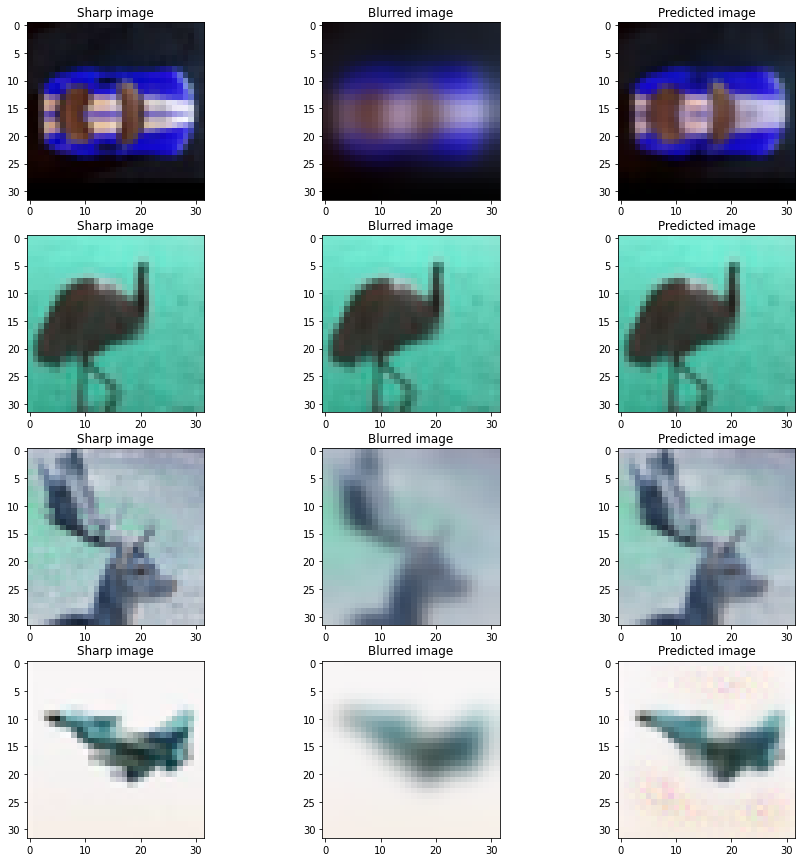

In [ ]:
for batch in test_data.take(1):
  blurred = tf.cast(batch[0], tf.float32)
  sharp = tf.cast(batch[1], tf.float32)
  predicted = tf.cast(rednet30.predict(blurred), tf.float32)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for i in range(4):
  axes[i, 0].set_title('Sharp image')
  axes[i, 0].imshow(sharp[i]);
  axes[i, 1].set_title('Blurred image')
  axes[i, 1].imshow(blurred[i]);
  axes[i, 2].set_title('Predicted image')
  axes[i, 2].imshow(predicted[i]);

### Approach 2: WGAN
This approach consists in using a Wasserstein Generative Adversarial Network with Gradient Penalty (WGAN-GP), in which the Generator is trained to generate realistic sharp versions of the blurred images received in input, whereas the Discriminator (called Critic) computes a score for each image (depending n whether such image is real or generated).

#### MSDeblurWGAN
The architecture experimented was a MultiScale DeblurWGAN.

In [ ]:
with strategy.scope():
  ms_deblur_wgan = MSDeblurWGAN((32, 32, 3),
                                last_act=False,
                                num_res_blocks=19)
ms_deblur_wgan.generator.summary()
ms_deblur_wgan.critic.summary()
init_ep = 0

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 8, 8, 3)      0           input_1[0][0]                    
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 8, 8, 64)     4864        lambda[0][0]                     
__________________________________________________________________________________________________
res_conv3_0_1 (Conv2D)          (None, 8, 8, 64)     102464      conv3[0][0]                      
__________________________________________________________________________________________

Load Cifar10 dataset from GCS.

In [ ]:
EP = 50
BS = 32 * strategy.num_replicas_in_sync

TRAINVAL_SIZE = 50000
VAL_SPLIT = 0.125
VAL_SIZE = int(VAL_SPLIT * TRAINVAL_SIZE)
TRAIN_SIZE = TRAINVAL_SIZE - VAL_SIZE
TEST_SIZE = 10000

# Load cifar10 dataset from GCS
train_data, test_data, val_data = cifar_dataset.load_data(BS, EP, VAL_SIZE, repeat=False, zero_mean=True)

steps_train = TRAIN_SIZE // BS + 1
steps_val = VAL_SIZE // BS + 1

print(f'Training set size: {TRAIN_SIZE}')
print(f'Validation set size: {VAL_SIZE}')
print(f'Test set size: {TEST_SIZE}')
print(f'Training step: {steps_train}')
print(f'Validation step: {steps_val}')

Training set size: 43750
Validation set size: 6250
Test set size: 10000
Training step: 171
Validation step: 25


Optionally load weights from previous run.

In [ ]:
import glob

g_model = glob.glob('/content/gen.h5')
d_model = glob.glob('/content/disc.h5')
ms_deblur_wgan.generator.load_weights(g_model[0])
ms_deblur_wgan.critic.load_weights(d_model[0])

Train model following *train-validation-test* paradigm.

In [ ]:
# Set chechpoint directory
checkpoint_dir = '/content/drive/My Drive/cnn-deblur/weights/cifar10/msdeblurwgan19_noact'

# Train using TPU
history = ms_deblur_wgan.distributed_fit(train_data,
                                         epochs=EP,
                                         steps_per_epoch=steps_train,
                                         strategy=strategy,
                                         initial_epoch=init_ep,
                                         validation_data=val_data,
                                         validation_steps=steps_val,
                                         checkpoint_dir=checkpoint_dir,
                                         checkpoint_freq=5)

Epoch 1/50



g_loss: 3.2572 - ssim: 0.3995 - psnr: 16.5384 - c_loss: 0.5196



val_g_loss: 0.5708 - val_ssim: 0.6421 - val_psnr: 22.6039 - val_c_loss: 0.0722
Epoch 2/50



g_loss: 0.6223 - ssim: 0.6458 - psnr: 22.5416 - c_loss: -0.0779



val_g_loss: 0.6562 - val_ssim: 0.6836 - val_psnr: 22.9566 - val_c_loss: 0.1212
Epoch 3/50



g_loss: 0.4482 - ssim: 0.7238 - psnr: 24.0126 - c_loss: -0.0972



val_g_loss: 0.4535 - val_ssim: 0.7086 - val_psnr: 22.9047 - val_c_loss: 0.0731
Epoch 4/50



g_loss: 0.3850 - ssim: 0.7637 - psnr: 24.8695 - c_loss: -0.1014



val_g_loss: 0.3052 - val_ssim: 0.7898 - val_psnr: 25.6105 - val_c_loss: 0.1379
Epoch 5/50



g_loss: 0.3413 - ssim: 0.7891 - psnr: 25.4761 - c_loss: -0.1016


Plot graphs representing the loss and metrics trends over epochs.

In [ ]:
n = np.arange(0, EP - init_ep)
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
fig.suptitle('Loss and metrics trends over epochs')
# Generator's loss
axes[0, 0].plot(n, history['g_loss'], label='train_g_loss')
axes[0, 0].plot(n, history['val_g_loss'], label='val_g_loss')
axes[0, 0].set_title('Generator\'s loss')
axes[0, 0].set(xlabel='Epochs #', ylabel='G. Loss')
axes[0, 0].legend();
# SSIM
axes[0, 1].plot(n, history['ssim'], label='train_ssim')
axes[0, 1].plot(n, history['val_ssim'], label='val_ssim')
axes[0, 1].set_title('SSIM')
axes[0, 1].set(xlabel='Epochs #', ylabel='SSIM')
axes[0, 1].legend();
# PSNR
axes[1, 0].plot(n, history['psnr'], label='train_psnr')
axes[1, 0].plot(n, history['val_psnr'], label='val_psnr')
axes[1, 0].set_title('PSNR')
axes[1, 0].set(xlabel='Epochs #', ylabel='PSNR')
axes[1, 0].legend();
# Critic's loss
axes[1, 1].plot(n, history['c_loss'], label='train_c_loss')
axes[1, 1].plot(n, history['val_c_loss'], label='val_c_loss')
axes[1, 1].set_title('Critic\'s loss')
axes[1, 1].set(xlabel='Epochs #', ylabel='C. Loss')
axes[1, 1].legend();
# Real L1
axes[2, 0].plot(n, history['real_l1'], label='train_real_l1')
axes[2, 0].plot(n, history['val_real_l1'], label='val_real_l1')
axes[2, 0].set_title('Real L1')
axes[2, 0].set(xlabel='Epochs #', ylabel='Real L1')
axes[2, 0].legend();
# Fake L1
axes[2, 1].plot(n, history['fake_l1'], label='train_fake_l1')
axes[2, 1].plot(n, history['val_fake_l1'], label='val_fake_l1')
axes[2, 1].set_title('Fake L1')
axes[2, 1].set(xlabel='Epochs #', ylabel='Fake L1')
axes[2, 1].legend();

Evaluate the model on the test set.

In [ ]:
steps_test = TEST_SIZE // BS + 1
ms_deblur_wgan.evaluate(test_data, steps=steps_test)


g_loss: 0.1497
ssim: 0.9011
psnr: 31.1763
c_loss: 0.0797


In [ ]:
from tensorflow.keras.metrics import mse, mae
from tqdm import notebook

mse_metrics, mae_metrics = [], []
for batch in notebook.tqdm(test_data, total=steps_test):
  # Get blurred, original
  blurred_batch1 = batch[0]
  sharp_batch1 = batch[1]
  # Determine height and width
  height = batch[0].shape[1]
  width = batch[0].shape[2]
  # Prepare Gaussian pyramid
  blurred_batch2 = tf.image.resize(batch[0], size=(height // 2, width // 2))
  sharp_batch2 = tf.image.resize(batch[1], size=(height // 2, width // 2))
  blurred_batch3 = tf.image.resize(batch[0], size=(height // 4, width // 4))
  sharp_batch3 = tf.image.resize(batch[1], size=(height // 4, width // 4))
  blurred_pyramid = [blurred_batch1, blurred_batch2, blurred_batch3]
  sharp_pyramid = [sharp_batch1, sharp_batch2, sharp_batch3]
  # Get predicted pyramid
  predicted_pyramid = ms_deblur_wgan.generator(blurred_pyramid)
  # Rescale from [-1, 1] to [0, 1]
  blurred_pyramid = [tf.divide(tf.add(blurred_img, 1.), 2.) for blurred_img in blurred_pyramid]
  sharp_pyramid = [tf.divide(tf.add(sharp_img, 1.), 2.) for sharp_img in sharp_pyramid]
  predicted_pyramid = [tf.divide(tf.add(predicted_img, 1.), 2.) for predicted_img in predicted_pyramid]
  # Cast tensor from bfloat16 to float32
  blurred_pyramid = [tf.cast(blurred_img, tf.float32) for blurred_img in blurred_pyramid]
  sharp_pyramid = [tf.cast(sharp_img, tf.float32) for sharp_img in sharp_pyramid]
  predicted_pyramid = [tf.cast(predicted_img, tf.float32) for predicted_img in predicted_pyramid]

  mse_metrics.append(tf.reduce_mean(mse(sharp_pyramid[0], predicted_pyramid[0])))
  mae_metrics.append(tf.reduce_mean(mae(sharp_pyramid[0], predicted_pyramid[0])))
print(f'MSE: {np.mean(mse_metrics)}')
print(f'MAE: {np.mean(mae_metrics)}')


MSE: 0.00634265411645174
MAE: 0.04866642504930496


Generate predictions on new data.

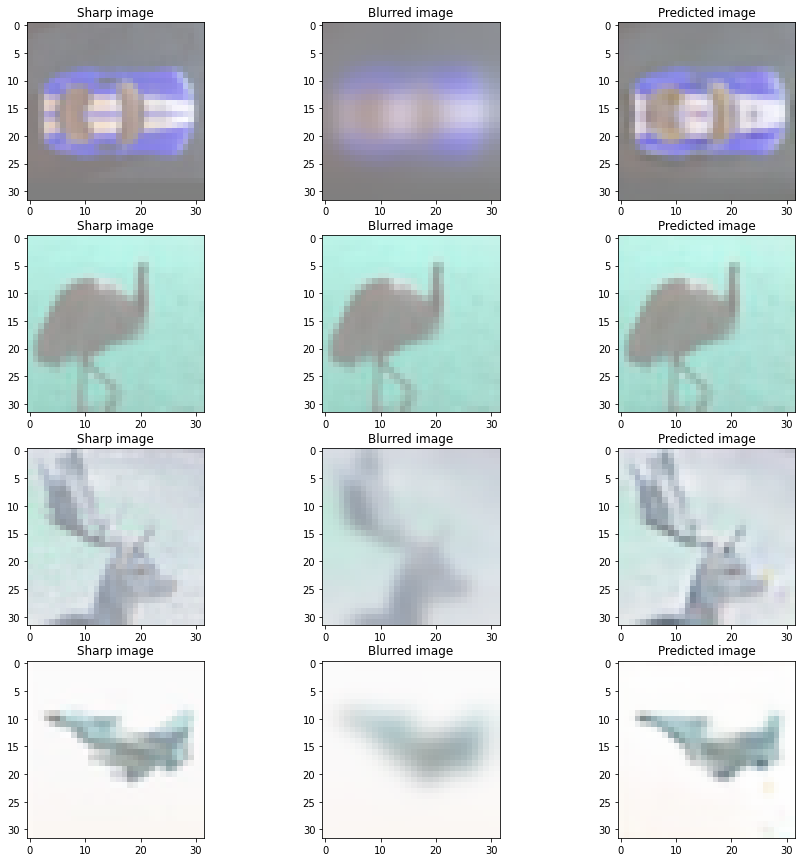

In [ ]:
for batch in test_data.take(1):
  # Get blurred, original
  blurred_batch1 = batch[0]
  sharp_batch1 = batch[1]
  # Determine height and width
  height = batch[0].shape[1]
  width = batch[0].shape[2]
  # Prepare Gaussian pyramid
  blurred_batch2 = tf.image.resize(batch[0], size=(height // 2, width // 2))
  sharp_batch2 = tf.image.resize(batch[1], size=(height // 2, width // 2))
  blurred_batch3 = tf.image.resize(batch[0], size=(height // 4, width // 4))
  sharp_batch3 = tf.image.resize(batch[1], size=(height // 4, width // 4))
  blurred_pyramid = [blurred_batch1, blurred_batch2, blurred_batch3]
  sharp_pyramid = [sharp_batch1, sharp_batch2, sharp_batch3]
  # Get predicted pyramid
  predicted_pyramid = ms_deblur_wgan.generator(blurred_pyramid)
  # Rescale from [-1, 1] to [0, 1]
  blurred_pyramid = [tf.divide(tf.add(blurred_img, 1.), 2.) for blurred_img in blurred_pyramid]
  sharp_pyramid = [tf.divide(tf.add(sharp_img, 1.), 2.) for sharp_img in sharp_pyramid]
  predicted_pyramid = [tf.divide(tf.add(predicted_img, 1.), 2.) for predicted_img in predicted_pyramid]
  # Cast tensor from bfloat16 to float32
  blurred_pyramid = [tf.cast(blurred_img, tf.float32) for blurred_img in blurred_pyramid]
  sharp_pyramid = [tf.cast(sharp_img, tf.float32) for sharp_img in sharp_pyramid]
  predicted_pyramid = [tf.cast(predicted_img, tf.float32) for predicted_img in predicted_pyramid]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for i in range(4):
  axes[i, 0].set_title('Sharp image')
  axes[i, 0].imshow(sharp_pyramid[0][i]);
  axes[i, 1].set_title('Blurred image')
  axes[i, 1].imshow(blurred_pyramid[0][i]);
  axes[i, 2].set_title('Predicted image')
  axes[i, 2].imshow(predicted_pyramid[0][i]);

#### REDNet30WGAN

In [ ]:
with strategy.scope():
  rednet_gan = REDNet30WGAN((32, 32, 3), use_elu=True)
rednet_gan.generator.summary()
rednet_gan.critic.summary()
init_ep = 0

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
encode_conv0 (Conv2D)           (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
encode_act0 (ELU)               (None, 32, 32, 64)   0           encode_conv0[0][0]               
__________________________________________________________________________________________________
encode_bn0 (BatchNormalization) (None, 32, 32, 64)   256         encode_act0[0][0]                
_______________________________________________________________________________________

In [ ]:
EP = 350
BS = 32 * strategy.num_replicas_in_sync

TRAINVAL_SIZE = 50000
VAL_SPLIT = 0.125
VAL_SIZE = int(VAL_SPLIT * TRAINVAL_SIZE)
TRAIN_SIZE = TRAINVAL_SIZE - VAL_SIZE
TEST_SIZE = 10000

# Load cifar10 dataset from GCS
train_data, test_data, val_data = cifar_dataset.load_data(BS, EP, VAL_SIZE, repeat=False, zero_mean=True)

steps_train = TRAIN_SIZE // BS + 1
steps_val = VAL_SIZE // BS + 1

print(f'Training set size: {TRAIN_SIZE}')
print(f'Validation set size: {VAL_SIZE}')
print(f'Test set size: {TEST_SIZE}')
print(f'Training step: {steps_train}')
print(f'Validation step: {steps_val}')

Training set size: 43750
Validation set size: 6250
Test set size: 10000
Training step: 171
Validation step: 25


In [ ]:
import glob

init_ep = int(input('Initial epoch: '))

g_model = glob.glob('/content/drive/My Drive/cnn-deblur/weights/cifar10/rednet_gan/ep:{0:03d}-ssim:*.h5'.format(init_ep))
d_model = glob.glob('/content/drive/My Drive/cnn-deblur/weights/cifar10/rednet_gan/ep:{0:03d}.h5'.format(init_ep))
rednet_gan.generator.load_weights(g_model[0])
rednet_gan.critic.load_weights(d_model[0])

Initial epoch: 350


In [ ]:
# Set chechpoint directory
checkpoint_dir = '/content/drive/My Drive/cnn-deblur/weights/cifar10/rednet_gan2'

# Train using TPU
history = rednet_gan.distributed_fit(train_data,
                                     epochs=EP,
                                     steps_per_epoch=steps_train,
                                     strategy=strategy,
                                     initial_epoch=init_ep,
                                     validation_data=val_data,
                                     validation_steps=steps_val,
                                     checkpoint_dir=checkpoint_dir,
                                     checkpoint_freq=5)

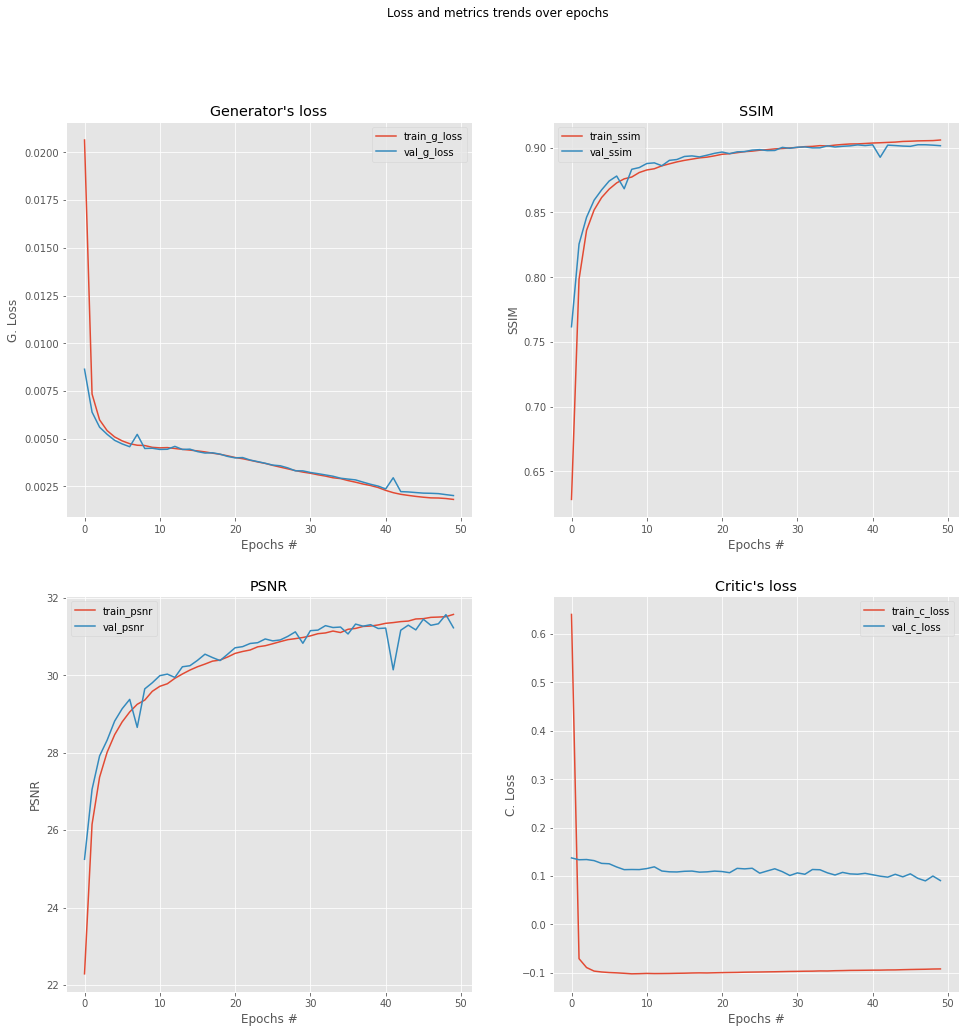

In [ ]:
n = np.arange(0, EP - init_ep)
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
fig.suptitle('Loss and metrics trends over epochs')
# Generator's loss
axes[0, 0].plot(n, history['g_loss'], label='train_g_loss')
axes[0, 0].plot(n, history['val_g_loss'], label='val_g_loss')
axes[0, 0].set_title('Generator\'s loss')
axes[0, 0].set(xlabel='Epochs #', ylabel='G. Loss')
axes[0, 0].legend();
# SSIM
axes[0, 1].plot(n, history['ssim'], label='train_ssim')
axes[0, 1].plot(n, history['val_ssim'], label='val_ssim')
axes[0, 1].set_title('SSIM')
axes[0, 1].set(xlabel='Epochs #', ylabel='SSIM')
axes[0, 1].legend();
# PSNR
axes[1, 0].plot(n, history['psnr'], label='train_psnr')
axes[1, 0].plot(n, history['val_psnr'], label='val_psnr')
axes[1, 0].set_title('PSNR')
axes[1, 0].set(xlabel='Epochs #', ylabel='PSNR')
axes[1, 0].legend();
# Critic's loss
axes[1, 1].plot(n, history['c_loss'], label='train_c_loss')
axes[1, 1].plot(n, history['val_c_loss'], label='val_c_loss')
axes[1, 1].set_title('Critic\'s loss')
axes[1, 1].set(xlabel='Epochs #', ylabel='C. Loss')
axes[1, 1].legend();

In [ ]:
steps_test = TEST_SIZE // BS + 1
rednet_gan.evaluate(test_data, steps=steps_test)


g_loss: -0.0057
ssim: 0.9012
psnr: 31.9755
c_loss: 0.0717


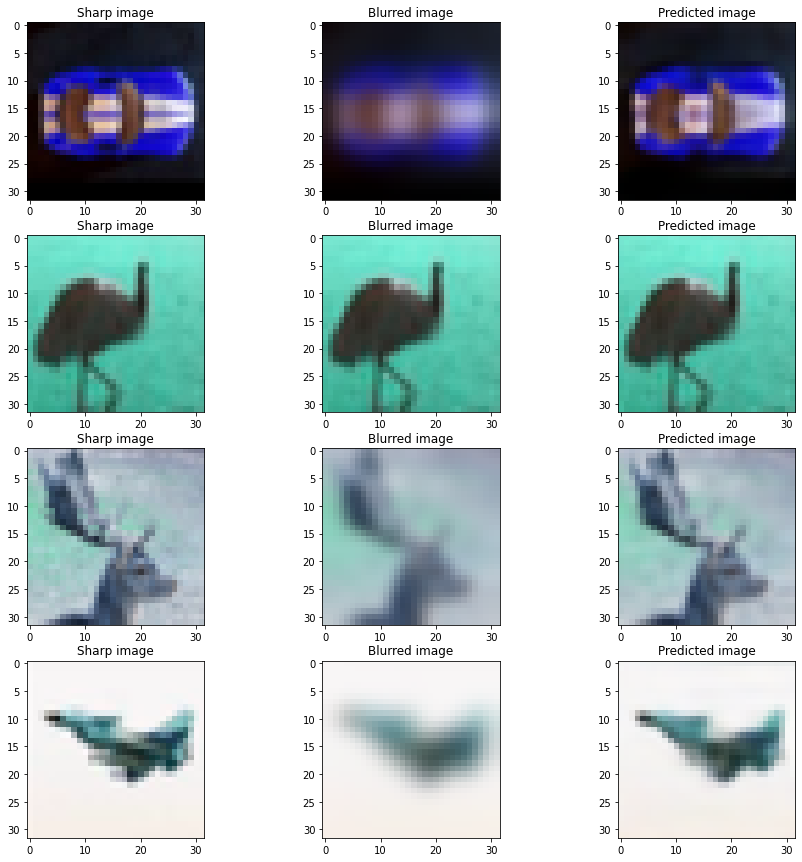

In [ ]:
for batch in test_data.take(1):
  # Get blurred, original
  blurred_batch = batch[0]
  sharp_batch = batch[1]
  # Get predicted batch
  predicted_batch = rednet_gan.generator(blurred_batch)
  # Rescale from [-1, 1] to [0, 1]
  blurred_batch = [tf.divide(tf.add(blurred_img, 1.), 2.) for blurred_img in blurred_batch]
  sharp_batch = [tf.divide(tf.add(sharp_img, 1.), 2.) for sharp_img in sharp_batch]
  predicted_batch = [tf.divide(tf.add(predicted_img, 1.), 2.) for predicted_img in predicted_batch]
  # Cast tensor from bfloat16 to float32
  blurred_batch = [tf.cast(blurred_img, tf.float32) for blurred_img in blurred_batch]
  sharp_batch = [tf.cast(sharp_img, tf.float32) for sharp_img in sharp_batch]
  predicted_batch = [tf.cast(predicted_img, tf.float32) for predicted_img in predicted_batch]

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for i in range(4):
  axes[i, 0].set_title('Sharp image')
  axes[i, 0].imshow(sharp_batch[i]);
  axes[i, 1].set_title('Blurred image')
  axes[i, 1].imshow(blurred_batch[i]);
  axes[i, 2].set_title('Predicted image')
  axes[i, 2].imshow(predicted_batch[i]);

In [ ]:
from tensorflow.keras.metrics import mse, mae
from tqdm import notebook

mse_metrics, mae_metrics = [], []
for batch in notebook.tqdm(test_data, total=steps_test):
  # Get blurred, original
  blurred_batch = batch[0]
  sharp_batch = batch[1]
  # Get predicted batch
  predicted_batch = rednet_gan.generator(blurred_batch)
  # Rescale from [-1, 1] to [0, 1]
  blurred_batch = [tf.divide(tf.add(blurred_img, 1.), 2.) for blurred_img in blurred_batch]
  sharp_batch = [tf.divide(tf.add(sharp_img, 1.), 2.) for sharp_img in sharp_batch]
  predicted_batch = [tf.divide(tf.add(predicted_img, 1.), 2.) for predicted_img in predicted_batch]
  # Cast tensor from bfloat16 to float32
  blurred_batch = [tf.cast(blurred_img, tf.float32) for blurred_img in blurred_batch]
  sharp_batch = [tf.cast(sharp_img, tf.float32) for sharp_img in sharp_batch]
  predicted_batch = [tf.cast(predicted_img, tf.float32) for predicted_img in predicted_batch]

  mse_metrics.append(tf.reduce_mean(mse(sharp_batch, predicted_batch)))
  mae_metrics.append(tf.reduce_mean(mae(sharp_batch, predicted_batch)))
print(f'MSE: {np.mean(mse_metrics)}')
print(f'MAE: {np.mean(mae_metrics)}')


MSE: 0.0019001159816980362
MAE: 0.024820953607559204


## 2. REDS

#### REDNet30

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
encode_conv0 (Conv2D)           (None, 96, 128, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
encode_act0 (ELU)               (None, 96, 128, 64)  0           encode_conv0[0][0]               
__________________________________________________________________________________________________
encode_bn0 (BatchNormalization) (None, 96, 128, 64)  256         encode_act0[0][0]                
_______________________________________________________________________________________

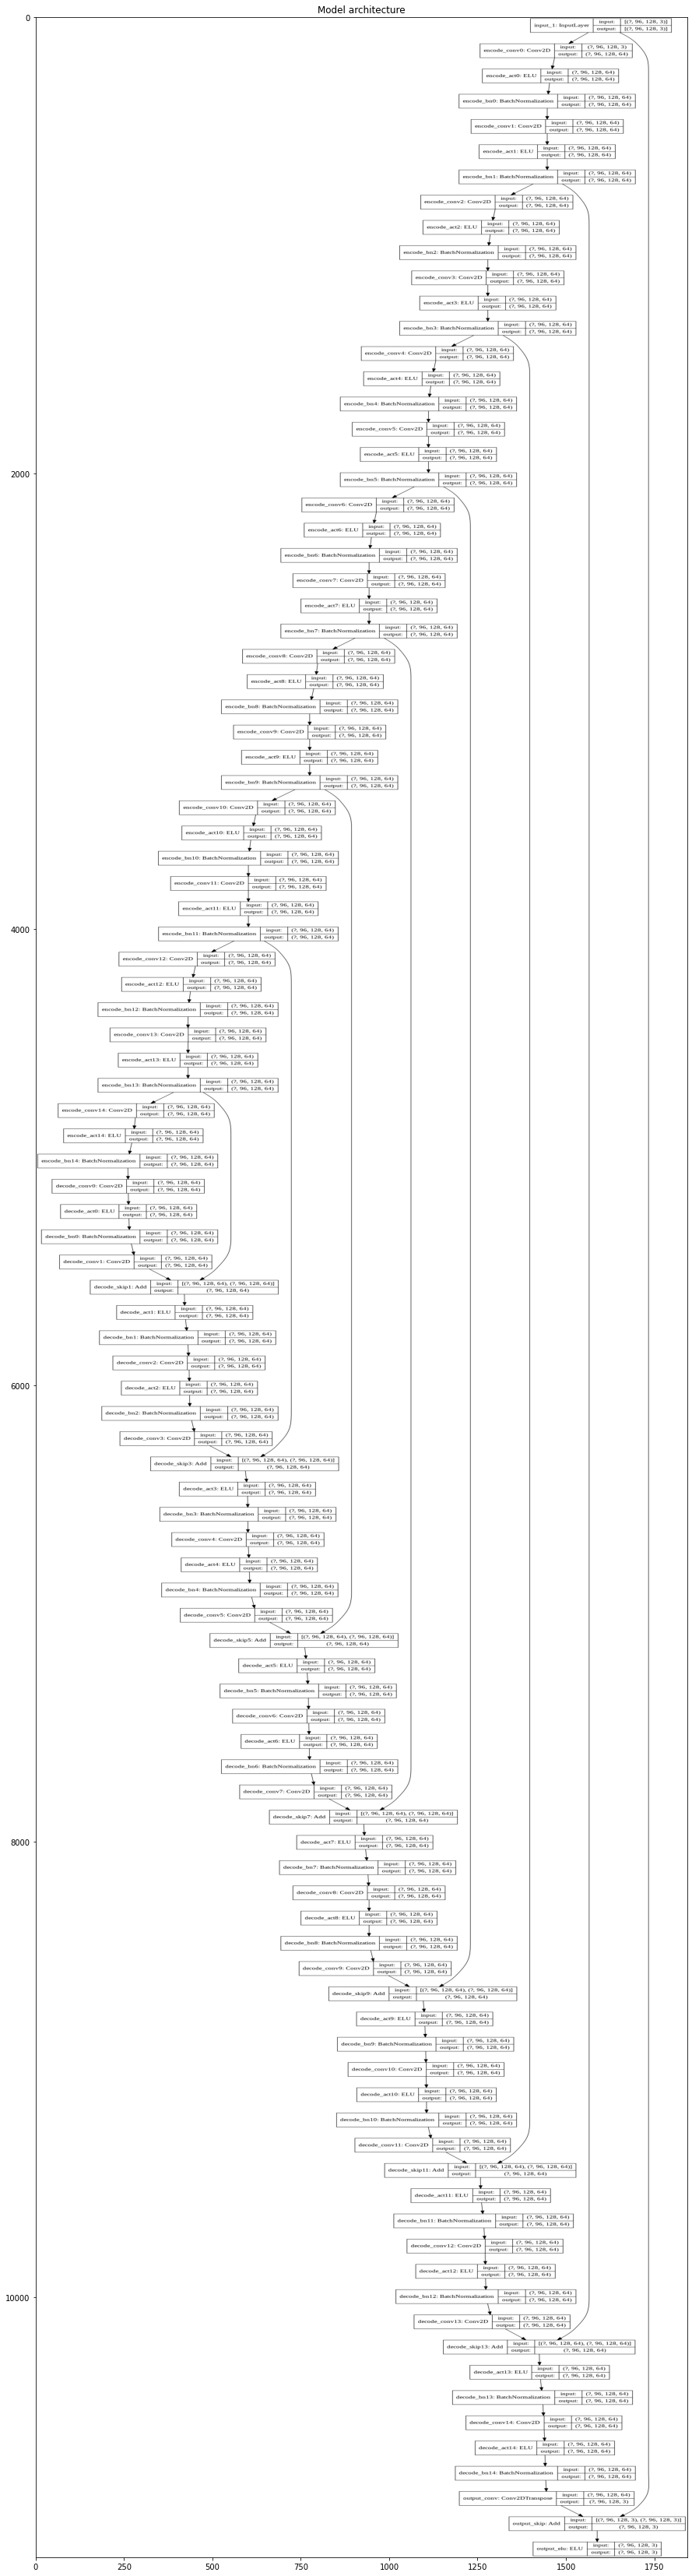

In [ ]:
# Create ConvNet and plot model
with strategy.scope():
  conv_net: ConvNet = REDNet30(input_shape=(96, 128, 3))
  LEARNING_RATE = 0.001  # previous: 0.1
  conv_net.compile(loss='logcosh', lr=LEARNING_RATE)

print(conv_net.summary())
path_to_model = os.path.join('..', 'res', 'model.png')
conv_net.plot_model(path_to_model)
fig, ax = plt.subplots(figsize=(15, 60))
ax.set_title('Model architecture')
plt.imshow(mpimg.imread(path_to_model), aspect='auto');

Prepare callback function to save weights to Drive.

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

filepath='/content/drive/My Drive/cnn-deblur/weights/REDS/ep:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='auto', period=5)
callbacks_list = [checkpoint]

Prepare callback function to decrease the learning rate.

In [ ]:
from math import floor

# Learning rate decay
DROP_RATE = 0.9
EPOCH_DROP = 5
lr_decay = tf.keras.callbacks.LearningRateScheduler(
  lambda epoch: LEARNING_RATE * DROP_RATE ** floor(epoch/EPOCH_DROP),
  verbose=True)

callbacks_list.append(lr_decay)

Load weights from previous run.

In [ ]:
import glob

init_ep = int(input('Initial epoch: '))

weights = glob.glob('/content/drive/My Drive/cnn-deblur/weights/REDS/rednet30/ep:{0:03d}-val_loss:*.hdf5'.format(init_ep))
conv_net.model.load_weights(weights[0])

Initial epoch: 95


Load REDS dataset from GCS.

In [ ]:
EP = 100
BS = 32 * strategy.num_replicas_in_sync

TRAINVAL_SIZE = 24000
VAL_SPLIT = 0.125
VAL_SIZE = int(VAL_SPLIT * TRAINVAL_SIZE)
TRAIN_SIZE = TRAINVAL_SIZE - VAL_SIZE
TEST_SIZE = 3000

train_data, test_data, val_data = reds_dataset.load_data(BS, EP, VAL_SIZE)

steps_train = 12 * TRAIN_SIZE // BS
steps_val = 12 * VAL_SIZE // BS

print(f'Training set size: {TRAIN_SIZE}')
print(f'Validation set size: {VAL_SIZE}')
print(f'Test set size: {TEST_SIZE}')
print(f'Training step: {steps_train}')
print(f'Validation step: {steps_val}')

Training set size: 21000
Validation set size: 3000
Test set size: 3000
Training step: 984
Validation step: 140


Train model following *train-validation-test* paradigm.

In [ ]:
if 'init_ep' not in locals():
  init_ep = 0
print('Initial epoch: {0:d}'.format(init_ep))

hist = conv_net.fit(train_data,
                    epochs=EP,
                    steps_per_epoch=steps_train,
                    validation_data=val_data,
                    validation_steps=steps_val,
                    initial_epoch=init_ep,
                    callbacks=callbacks_list);

Initial epoch: 80
Epoch 81/100
984/984 [==============================] - 638s 648ms/step - psnr: 31.3687 - mae: 0.0204 - mse: 0.0014 - accuracy: 0.9328 - ssim: 0.8997 - loss: 6.9888e-04 - val_psnr: 29.7431 - val_mae: 0.0233 - val_mse: 0.0018 - val_accuracy: 0.9108 - val_ssim: 0.8771 - val_loss: 8.7643e-04
Epoch 82/100
984/984 [==============================] - 556s 565ms/step - psnr: 31.3738 - mae: 0.0206 - mse: 0.0014 - accuracy: 0.9316 - ssim: 0.8984 - loss: 7.1671e-04 - val_psnr: 30.2634 - val_mae: 0.0220 - val_mse: 0.0016 - val_accuracy: 0.9262 - val_ssim: 0.8862 - val_loss: 8.0780e-04
Epoch 83/100
984/984 [==============================] - 510s 518ms/step - psnr: 31.5469 - mae: 0.0205 - mse: 0.0015 - accuracy: 0.9307 - ssim: 0.8991 - loss: 7.3794e-04 - val_psnr: 30.2539 - val_mae: 0.0220 - val_mse: 0.0016 - val_accuracy: 0.9282 - val_ssim: 0.8864 - val_loss: 7.9933e-04
Epoch 84/100
984/984 [==============================] - 509s 518ms/step - psnr: 31.4633 - mae: 0.0206 - mse: 0.0

Plot graphs representing the loss and metrics trends over epochs.

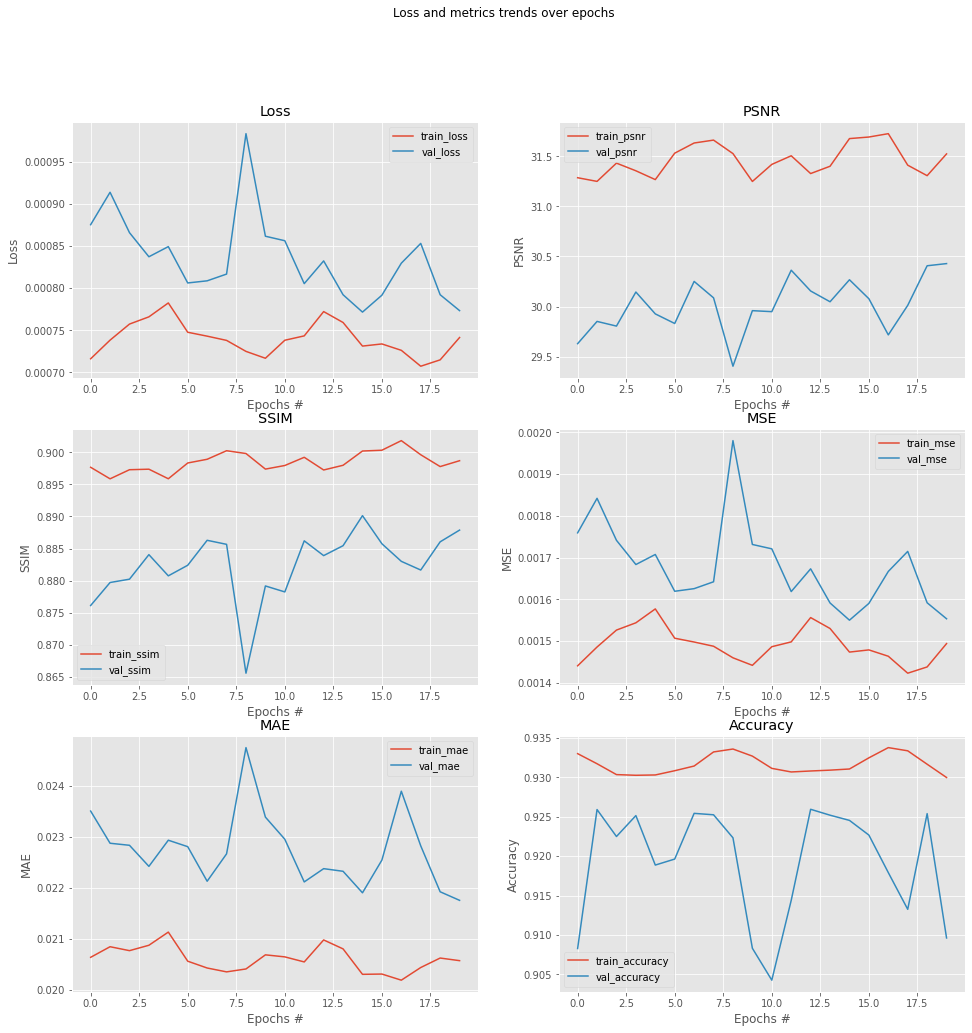

In [ ]:
n = np.arange(0, EP - init_ep)
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 16))
fig.suptitle('Loss and metrics trends over epochs')
# Loss
axes[0, 0].plot(n, hist.history['loss'], label='train_loss')
axes[0, 0].plot(n, hist.history['val_loss'], label='val_loss')
axes[0, 0].set_title('Loss')
axes[0, 0].set(xlabel='Epochs #', ylabel='Loss')
axes[0, 0].legend();
# PSNR
axes[0, 1].plot(n, hist.history['psnr'], label='train_psnr')
axes[0, 1].plot(n, hist.history['val_psnr'], label='val_psnr')
axes[0, 1].set_title('PSNR')
axes[0, 1].set(xlabel='Epochs #', ylabel='PSNR')
axes[0, 1].legend();
# SSIM
axes[1, 0].plot(n, hist.history['ssim'], label='train_ssim')
axes[1, 0].plot(n, hist.history['val_ssim'], label='val_ssim')
axes[1, 0].set_title('SSIM')
axes[1, 0].set(xlabel='Epochs #', ylabel='SSIM')
axes[1, 0].legend();
# MSE
axes[1, 1].plot(n, hist.history['mse'], label='train_mse')
axes[1, 1].plot(n, hist.history['val_mse'], label='val_mse')
axes[1, 1].set_title('MSE')
axes[1, 1].set(xlabel='Epochs #', ylabel='MSE')
axes[1, 1].legend();
# MAE
axes[2, 0].plot(n, hist.history['mae'], label='train_mae')
axes[2, 0].plot(n, hist.history['val_mae'], label='val_mae')
axes[2, 0].set_title('MAE')
axes[2, 0].set(xlabel='Epochs #', ylabel='MAE')
axes[2, 0].legend();
# Accuracy
axes[2, 1].plot(n, hist.history['accuracy'], label='train_accuracy')
axes[2, 1].plot(n, hist.history['val_accuracy'], label='val_accuracy')
axes[2, 1].set_title('Accuracy')
axes[2, 1].set(xlabel='Epochs #', ylabel='Accuracy')
axes[2, 1].legend();

Evaluate model on the test set.

In [ ]:
# Extract patches from test set and batch
steps_test = 12 * TEST_SIZE // BS
results = conv_net.evaluate(extract_patches_from_dataset(test_data).batch(BS), steps=steps_test)
print('Test loss:', results[0])
print('Test ssim:', results[1])
print('Test psnr:', results[2])
print('Test mse:', results[3])
print('Test mae:', results[4])
print('Test accuracy:', results[5])

140/140 [==============================] - 54s 384ms/step - loss: 5.6519e-04 - ssim: 0.9012 - psnr: 31.8611 - mse: 0.0011 - mae: 0.0188 - accuracy: 0.9237
Test loss: 0.0005651862593367696
Test ssim: 0.9012281894683838
Test psnr: 31.861053466796875
Test mse: 0.0011353102745488286
Test mae: 0.018785618245601654
Test accuracy: 0.9237184524536133


In [ ]:
from tensorflow.keras.metrics import mse, mae
from tensorflow.keras.losses import log_cosh
from utils.custom_metrics import ssim, psnr
from tqdm import notebook

logcosh_metrics = []
ssim_metrics, psnr_metrics = [], []
mse_metrics, mae_metrics = [], []
steps_test = 12 * TEST_SIZE // BS + 1
batched_test = extract_patches_from_dataset(test_data).batch(BS)
for batch in notebook.tqdm(batched_test, total=steps_test):
  # Get blurred, original
  blurred_batch = batch[0]
  sharp_batch = batch[1]

  logcosh_metrics.append(tf.cast(tf.reduce_mean(log_cosh(sharp_batch, blurred_batch)), dtype=tf.float32))
  ssim_metrics.append(tf.cast(tf.reduce_mean(ssim(sharp_batch, blurred_batch)), dtype=tf.float32))
  psnr_metrics.append(tf.cast(tf.reduce_mean(psnr(sharp_batch, blurred_batch)), dtype=tf.float32))
  mse_metrics.append(tf.cast(tf.reduce_mean(mse(sharp_batch, blurred_batch)), dtype=tf.float32))
  mae_metrics.append(tf.cast(tf.reduce_mean(mae(sharp_batch, blurred_batch)), dtype=tf.float32))

print(f'LogCosh: {np.mean(logcosh_metrics)}')
print(f'SSIM: {np.mean(ssim_metrics)}')
print(f'PSNR: {np.mean(psnr_metrics)}')
print(f'MSE: {np.mean(mse_metrics)}')
print(f'MAE: {np.mean(mae_metrics)}')


LogCosh: 0.0019535578321665525
SSIM: 0.823673665523529
PSNR: 28.804039001464844
MSE: 0.002593777608126402
MAE: 0.02117919921875


Generate predictions on new data.

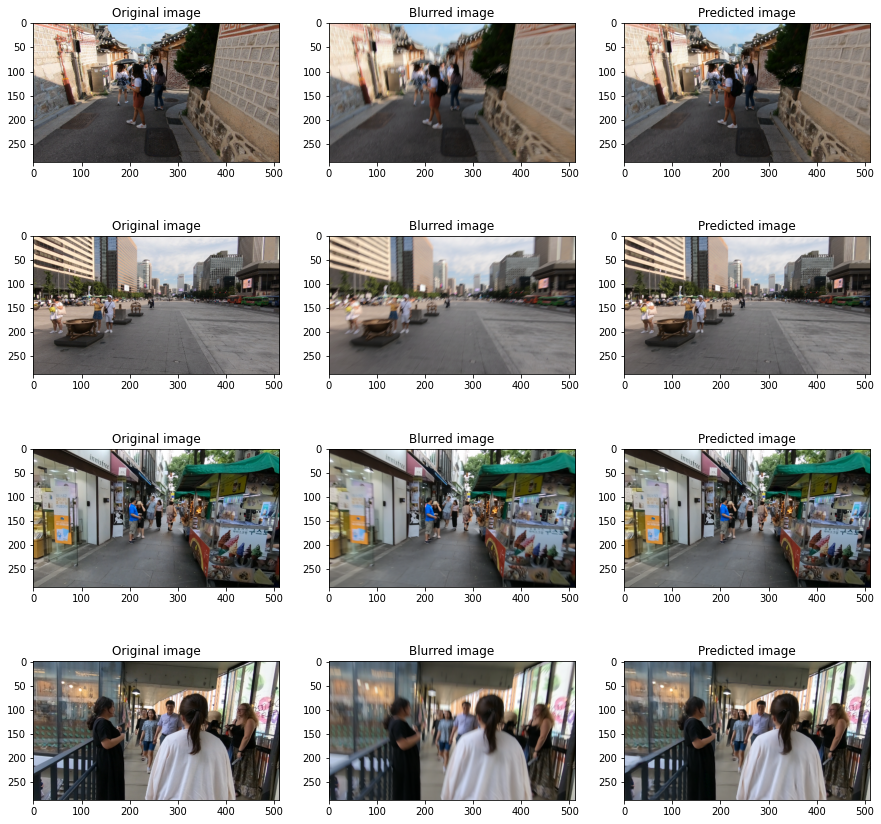

In [ ]:
blurred = []
original = []
predicted = []

for batch in test_data.take(4):
  blurred.append(tf.cast(batch[0], tf.float32))
  original.append(tf.cast(batch[1], tf.float32))

  blurred_patches = extract_patches(batch[0])
  predicted_patches = tf.cast(conv_net.predict(blurred_patches), tf.float32)
  predicted.append(reconstruct_image(predicted_patches, (3, 4)))

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for i in range(4):
  axes[i, 0].set_title('Original image')
  axes[i, 0].imshow(original[i]);
  axes[i, 1].set_title('Blurred image')
  axes[i, 1].imshow(blurred[i]);
  axes[i, 2].set_title('Predicted image')
  axes[i, 2].imshow(predicted[i]);

#### MSDeblurWGAN

In [ ]:
with strategy.scope():
  ms_deblur_wgan = MSDeblurWGAN((48, 64, 3),
                                last_act=False,
                                num_res_blocks=5)
ms_deblur_wgan.generator.summary()
ms_deblur_wgan.critic.summary()
init_ep = 0

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 48, 64, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 12, 16, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 12, 16, 64)   4864        lambda[0][0]                     
__________________________________________________________________________________________________
res_conv3_0_1 (Conv2D)          (None, 12, 16, 64)   102464      conv3[0][0]                      
__________________________________________________________________________________________

In [ ]:
EP = 100
BS = 32 * strategy.num_replicas_in_sync

TRAINVAL_SIZE = 24000
VAL_SPLIT = 0.125
VAL_SIZE = int(VAL_SPLIT * TRAINVAL_SIZE)
TRAIN_SIZE = TRAINVAL_SIZE - VAL_SIZE
TEST_SIZE = 3000

train_data, test_data, val_data = reds_dataset.load_data(BS, EP, VAL_SIZE, repeat=False, zero_mean=False, low_res=True)

steps_train = 12 * TRAIN_SIZE // BS + 1
steps_val = 12 * VAL_SIZE // BS + 1

print(f'Training set size: {TRAIN_SIZE}')
print(f'Validation set size: {VAL_SIZE}')
print(f'Test set size: {TEST_SIZE}')
print(f'Training step: {steps_train}')
print(f'Validation step: {steps_val}')

Training set size: 21000
Validation set size: 3000
Test set size: 3000
Training step: 985
Validation step: 141


In [ ]:
import glob

init_ep = int(input('Initial epoch: '))

g_model = glob.glob('/content/drive/My Drive/cnn-deblur/weights/REDS/msdeblurwgan_noact/ep:{0:03d}-ssim:*.h5'.format(init_ep))
d_model = glob.glob('/content/drive/My Drive/cnn-deblur/weights/REDS/msdeblurwgan_noact/ep:{0:03d}.h5'.format(init_ep))
ms_deblur_wgan.generator.load_weights(g_model[0])
ms_deblur_wgan.critic.load_weights(d_model[0])

Initial epoch: 100


In [ ]:
# Set chechpoint directory
checkpoint_dir = '/content/drive/My Drive/cnn-deblur/weights/REDS/msdeblurwgan_noact'

# Train using TPU
history = ms_deblur_wgan.distributed_fit(train_data,
                                         epochs=EP,
                                         steps_per_epoch=steps_train,
                                         strategy=strategy,
                                         initial_epoch=init_ep,
                                         validation_data=val_data,
                                         validation_steps=steps_val,
                                         checkpoint_dir=checkpoint_dir,
                                         checkpoint_freq=1)

Epoch 97/100



g_loss: 0.1919 - ssim: 0.8492 - psnr: 28.5955 - c_loss: -0.0623



val_g_loss: 0.2832 - val_ssim: 0.7599 - val_psnr: 24.9654 - val_c_loss: 0.1115
Saving generator's model... OK
Saving critic's model... OK
Epoch 98/100



g_loss: 0.1911 - ssim: 0.8498 - psnr: 28.6187 - c_loss: -0.0621



val_g_loss: 0.2645 - val_ssim: 0.7715 - val_psnr: 25.1864 - val_c_loss: 0.1099
Saving generator's model... OK
Saving critic's model... OK
Epoch 99/100



g_loss: 0.1912 - ssim: 0.8498 - psnr: 28.6219 - c_loss: -0.0619



val_g_loss: 0.2802 - val_ssim: 0.7661 - val_psnr: 25.0558 - val_c_loss: 0.1095
Saving generator's model... OK
Saving critic's model... OK
Epoch 100/100



g_loss: 0.1918 - ssim: 0.8497 - psnr: 28.6123 - c_loss: -0.0618



val_g_loss: 0.2847 - val_ssim: 0.7597 - val_psnr: 24.9820 - val_c_loss: 0.1128
Saving generator's model... OK
Saving critic's model... OK



In [ ]:
steps_test = 12 * TEST_SIZE // BS + 1
ms_deblur_wgan.evaluate(extract_patches_from_dataset(test_data).batch(BS), steps=steps_test)


g_loss: 0.2195
ssim: 0.8031
psnr: 27.1133
c_loss: 0.0884


In [ ]:
from tensorflow.keras.metrics import mse, mae
from tqdm import notebook

mse_metrics, mae_metrics = [], []
for batch in notebook.tqdm(test_data, total=steps_test):
  # Get blurred, original
  blurred_batch1 = batch[0]
  sharp_batch1 = batch[1]
  # Determine height and width
  height = batch[0].shape[1]
  width = batch[0].shape[2]
  # Prepare Gaussian pyramid
  blurred_batch2 = tf.image.resize(batch[0], size=(height // 2, width // 2))
  sharp_batch2 = tf.image.resize(batch[1], size=(height // 2, width // 2))
  blurred_batch3 = tf.image.resize(batch[0], size=(height // 4, width // 4))
  sharp_batch3 = tf.image.resize(batch[1], size=(height // 4, width // 4))
  blurred_pyramid = [blurred_batch1, blurred_batch2, blurred_batch3]
  sharp_pyramid = [sharp_batch1, sharp_batch2, sharp_batch3]
  # Get predicted pyramid
  predicted_pyramid = ms_deblur_wgan.generator(blurred_pyramid)
  # Rescale from [-1, 1] to [0, 1]
  blurred_pyramid = [tf.divide(tf.add(blurred_img, 1.), 2.) for blurred_img in blurred_pyramid]
  sharp_pyramid = [tf.divide(tf.add(sharp_img, 1.), 2.) for sharp_img in sharp_pyramid]
  predicted_pyramid = [tf.divide(tf.add(predicted_img, 1.), 2.) for predicted_img in predicted_pyramid]
  # Cast tensor from bfloat16 to float32
  blurred_pyramid = [tf.cast(blurred_img, tf.float32) for blurred_img in blurred_pyramid]
  sharp_pyramid = [tf.cast(sharp_img, tf.float32) for sharp_img in sharp_pyramid]
  predicted_pyramid = [tf.cast(predicted_img, tf.float32) for predicted_img in predicted_pyramid]

  mse_metrics.append(tf.reduce_mean(mse(sharp_pyramid[0], predicted_pyramid[0])))
  mae_metrics.append(tf.reduce_mean(mae(sharp_pyramid[0], predicted_pyramid[0])))
print(f'MSE: {np.mean(mse_metrics)}')
print(f'MAE: {np.mean(mae_metrics)}')


MSE: 0.001729086972773075
MAE: 0.024948885664343834


In [ ]:
from tensorflow.keras.metrics import mse, mae
from utils.custom_metrics import ssim, psnr
from tqdm import notebook

ssim_metrics, psnr_metrics = [], []
mse_metrics, mae_metrics = [], []
steps_test = 12 * TEST_SIZE // BS + 1
batched_test = extract_patches_from_dataset(test_data).batch(BS)
for batch in notebook.tqdm(batched_test, total=steps_test):
  # Get blurred, original
  blurred_batch = batch[0]
  sharp_batch = batch[1]

  ssim_metrics.append(tf.cast(tf.reduce_mean(ssim(sharp_batch, blurred_batch)), dtype=tf.float32))
  psnr_metrics.append(tf.cast(tf.reduce_mean(psnr(sharp_batch, blurred_batch)), dtype=tf.float32))
  mse_metrics.append(tf.cast(tf.reduce_mean(mse(sharp_batch, blurred_batch)), dtype=tf.float32))
  mae_metrics.append(tf.cast(tf.reduce_mean(mae(sharp_batch, blurred_batch)), dtype=tf.float32))

print(f'SSIM: {np.mean(ssim_metrics)}')
print(f'PSNR: {np.mean(psnr_metrics)}')
print(f'MSE: {np.mean(mse_metrics)}')
print(f'MAE: {np.mean(mae_metrics)}')


SSIM: 0.8358758091926575
PSNR: 27.677982330322266
MSE: 0.003120151814073324
MAE: 0.023899808526039124


#### REDNet30WGAN

In [ ]:
 with strategy.scope():
  rednet_gan = REDNet30WGAN((96, 128, 3))
rednet_gan.generator.summary()
rednet_gan.critic.summary()
init_ep = 0

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
encode_conv0 (Conv2D)           (None, 96, 128, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
encode_act0 (ELU)               (None, 96, 128, 64)  0           encode_conv0[0][0]               
__________________________________________________________________________________________________
encode_bn0 (BatchNormalization) (None, 96, 128, 64)  256         encode_act0[0][0]                
_______________________________________________________________________________________

In [ ]:
EP = 50
BS = 8 * strategy.num_replicas_in_sync

TRAINVAL_SIZE = 24000
VAL_SPLIT = 0.125
VAL_SIZE = int(VAL_SPLIT * TRAINVAL_SIZE)
TRAIN_SIZE = TRAINVAL_SIZE - VAL_SIZE
TEST_SIZE = 3000

train_data, test_data, val_data = reds_dataset.load_data(BS, EP, VAL_SIZE, repeat=False, zero_mean=True)

steps_train = 12 * TRAIN_SIZE // BS + 1
steps_val = 12 * VAL_SIZE // BS + 1

print(f'Training set size: {TRAIN_SIZE}')
print(f'Validation set size: {VAL_SIZE}')
print(f'Test set size: {TEST_SIZE}')
print(f'Training step: {steps_train}')
print(f'Validation step: {steps_val}')

Training set size: 21000
Validation set size: 3000
Test set size: 3000
Training step: 3938
Validation step: 563


In [ ]:
import glob

init_ep = int(input('Initial epoch: '))

g_model = glob.glob('/content/drive/My Drive/cnn-deblur/weights/REDS/rednet_gan/ep:{0:03d}-ssim:*.h5'.format(init_ep))
d_model = glob.glob('/content/drive/My Drive/cnn-deblur/weights/REDS/rednet_gan/ep:{0:03d}.h5'.format(init_ep))
rednet_gan.generator.load_weights(g_model[0])
rednet_gan.critic.load_weights(d_model[0])

In [ ]:
# Set chechpoint directory
checkpoint_dir = '/content/drive/My Drive/cnn-deblur/weights/REDS/rednet_gan'

# Train using TPU
history = rednet_gan.distributed_fit(train_data,
                                     epochs=EP,
                                     steps_per_epoch=steps_train,
                                     strategy=strategy,
                                     initial_epoch=init_ep,
                                     validation_data=val_data,
                                     validation_steps=steps_val,
                                     checkpoint_dir=checkpoint_dir,
                                     checkpoint_freq=5)

In [ ]:
steps_test = TEST_SIZE // BS + 1
rednet_gan.evaluate(test_data, steps=steps_test)